In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import optuna
from sklearn.metrics import mean_squared_error, log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from src.data_loading import download_daily_prices, load_daily_close
from src.signals import (
    make_basic_signals,
    build_feature_matrix,
    build_sequence_dataset,
    DEFAULT_FEATURES,
)
from src.models_tree import train_tree_regressor, evaluate_regression
from src.models_lstm_class import train_lstm_classifier, predict_lstm_proba
from src.models_lstm import train_lstm_regressor, predict_lstm
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)
from src.models_tcn import train_tcn_regressor, predict_tcn
from src.models_tcn import train_tcn_regressor, predict_tcn
from src.models_transformer import train_transformer_regressor, predict_transformer




PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sharpe_ratio_np(returns: np.ndarray, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    mean = returns.mean()
    std = returns.std()
    if std == 0:
        return 0.0
    return np.sqrt(freq) * mean / std


In [3]:
ticker = "SPY"

# Load or download prices
try:
    prices = load_daily_close(ticker)
except FileNotFoundError:
    download_daily_prices(ticker, start="2010-01-01")
    prices = load_daily_close(ticker)

signals_df = make_basic_signals(prices)
signals_df.head(), signals_df.columns


c:\Users\gehra\Documents\GitHub\Quant_coding\src\data_loading.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)


(                price     ret_1     ret_5    ret_10    ret_21    vol_10  \
 date                                                                      
 2010-10-18  90.276466  0.004928  0.013973  0.039824  0.051472  0.006651   
 2010-10-19  89.093422 -0.013105 -0.002393  0.005946  0.022065  0.005921   
 2010-10-20  89.963554  0.009767 -0.000424  0.015858  0.034129  0.006576   
 2010-10-21  90.161972  0.002206  0.005704  0.019329  0.041527  0.006503   
 2010-10-22  90.329887  0.001862  0.005523  0.015531  0.052000  0.006374   
 
               vol_20    vol_60  vol_ratio_10_60  ma10_rel  ma20_rel  ma50_rel  \
 date                                                                            
 2010-10-18  0.007711  0.009786         0.679635 -0.011228 -0.023444 -0.056598   
 2010-10-19  0.008369  0.009886         0.598926  0.002493 -0.009299 -0.043327   
 2010-10-20  0.008446  0.009951         0.660826 -0.005642 -0.016994 -0.051547   
 2010-10-21  0.008106  0.009904         0.656599 -0.0059

In [4]:
feature_names = DEFAULT_FEATURES

X, y, dates = build_feature_matrix(signals_df, feature_names)

split_idx = int(len(X) * 0.7)  # 70% train / 30% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train_float, y_test_float = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train period:", dates_train[0], "->", dates_train[-1])
print("Test period:", dates_test[0], "->", dates_test[-1])

# Standardise features for LSTM regressor
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape


Train size: 2664 Test size: 1143
Train period: 2010-10-18 00:00:00 -> 2021-05-18 00:00:00
Test period: 2021-05-19 00:00:00 -> 2025-12-04 00:00:00


((2664, 15), (1143, 15))

In [5]:
# ---------------------------
# Optuna tuning: Tree model (Sharpe-based)
# ---------------------------
def objective_tree(trial):
    # Hyperparameters of the tree
    max_depth = trial.suggest_int("max_depth", 2, 8)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    l2_reg = trial.suggest_float("l2_regularization", 0.0, 1.0)

    # Trading hyperparameter: quantile for threshold
    q = trial.suggest_float("q", 0.4, 0.9)  # e.g. 40%–90% quantile

    # Chronological split of X_train into inner-train / validation
    n = len(X_train)
    split = int(n * 0.8)
    X_tr, X_val = X_train[:split], X_train[split:]
    y_tr, y_val = y_train_float[:split], y_train_float[split:]

    # Train tree on inner-train
    model = train_tree_regressor(
        X_tr,
        y_tr,
        max_depth=max_depth,
        max_iter=max_iter,
        learning_rate=learning_rate,
        l2_regularization=l2_reg,
    )

    # Predict on inner-val
    preds_val = model.predict(X_val)

    # Ranking rule on validation:
    # only long when prediction is above q-quantile of preds_val
    tau_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_val).astype(int)
    strat_ret_val = positions_val * y_val  # actual next-day returns

    # Strategy Sharpe on validation slice
    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> return negative Sharpe
    return -sharpe_val



study_tree = optuna.create_study(direction="minimize")
study_tree.optimize(objective_tree, n_trials=10)

print("Best tree params:", study_tree.best_params)


[I 2025-12-14 09:33:26,257] A new study created in memory with name: no-name-1b1b988b-3d81-47f0-824f-00d7cc0a0f07
[I 2025-12-14 09:33:32,484] Trial 0 finished with value: -0.8132629301849574 and parameters: {'max_depth': 8, 'max_iter': 312, 'learning_rate': 0.1066536609106173, 'l2_regularization': 0.44309307269281006, 'q': 0.4618908948542226}. Best is trial 0 with value: -0.8132629301849574.
[I 2025-12-14 09:33:32,746] Trial 1 finished with value: -0.5959232895073306 and parameters: {'max_depth': 4, 'max_iter': 168, 'learning_rate': 0.1000156940322922, 'l2_regularization': 0.6798044890142788, 'q': 0.7159836551639787}. Best is trial 0 with value: -0.8132629301849574.
[I 2025-12-14 09:33:33,338] Trial 2 finished with value: -0.581543952344208 and parameters: {'max_depth': 5, 'max_iter': 348, 'learning_rate': 0.01269323706658662, 'l2_regularization': 0.5898247381807775, 'q': 0.6809865423480009}. Best is trial 0 with value: -0.8132629301849574.
[I 2025-12-14 09:33:33,598] Trial 3 finished 

Best tree params: {'max_depth': 7, 'max_iter': 412, 'learning_rate': 0.08017551910641366, 'l2_regularization': 0.9155741129289671, 'q': 0.6657538201816535}


In [6]:
# --- Tree with best Optuna params (model + trading rule) ---
best_tree_params = study_tree.best_params
q_tree = best_tree_params["q"]

# Params for the sklearn model (exclude q)
tree_model_params = {k: v for k, v in best_tree_params.items() if k != "q"}

tree_model = train_tree_regressor(
    X_train,
    y_train_float,
    **tree_model_params,
)

# Predictions on train/test
preds_tree_train = tree_model.predict(X_train)
preds_tree_test  = tree_model.predict(X_test)

# Threshold based on train predictions and tuned q
tau_tree = np.quantile(preds_tree_train, q_tree)
print("Tree q_best:", q_tree, " -> tau_tree:", tau_tree)

# Trading rule on test
positions_tree = (preds_tree_test > tau_tree).astype(int)

# Returns on full test period
bh_returns = y_test_float                              # buy & hold
tree_returns = positions_tree * y_test_float           # tree strategy

# Series for full test period (we'll align later)
bh_series_full = signals_df["target_ret_1"].iloc[split_idx:].copy()
bh_series_full[:] = bh_returns

tree_series_full = bh_series_full.copy()
tree_series_full[:] = tree_returns


bh_series_full.head(), tree_series_full.head()


Tree q_best: 0.6657538201816535  -> tau_tree: 0.0015309405661252228


(date
 2021-05-19    0.010758
 2021-05-20   -0.000819
 2021-05-21    0.010194
 2021-05-24   -0.002219
 2021-05-25    0.001985
 Name: target_ret_1, dtype: float64,
 date
 2021-05-19    0.0
 2021-05-20   -0.0
 2021-05-21    0.0
 2021-05-24   -0.0
 2021-05-25    0.0
 Name: target_ret_1, dtype: float64)

In [7]:
# Direction labels for single-day features (no sequences)
y_train_class_simple = (y_train_float > 0).astype(int)
y_test_class_simple  = (y_test_float > 0).astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_class_simple)

y_pred_simple = log_reg.predict(X_test)

base_rate_simple = y_test_class_simple.mean()
acc_simple = accuracy_score(y_test_class_simple, y_pred_simple)
bacc_simple = balanced_accuracy_score(y_test_class_simple, y_pred_simple)

print("Base rate (simple):", base_rate_simple)
print("LogReg accuracy:", acc_simple)
print("LogReg balanced acc:", bacc_simple)


Base rate (simple): 0.5476815398075241
LogReg accuracy: 0.5476815398075241
LogReg balanced acc: 0.5


In [8]:
seq_len = 30

# --- Sequences for CLASSIFIER (unscaled features) ---
X_train_seq, y_train_seq_float, dates_train_seq = build_sequence_dataset(
    X_train, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq, y_test_seq_float, dates_test_seq = build_sequence_dataset(
    X_test, y_test_float, dates_test, seq_len=seq_len
)

# Labels for classifier
y_train_seq_class = (y_train_seq_float > 0).astype(np.float32)
y_test_seq_class  = (y_test_seq_float > 0).astype(np.float32)

print("Classifier sequences:", X_train_seq.shape, X_test_seq.shape)
print("Fraction up days (train/test):", y_train_seq_class.mean(), y_test_seq_class.mean())

# --- Sequences for REGRESSOR (scaled features) ---
X_train_seq_reg, y_train_seq_reg_float, dates_train_seq_reg = build_sequence_dataset(
    X_train_scaled, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq_reg, y_test_seq_reg_float, dates_test_seq_reg = build_sequence_dataset(
    X_test_scaled, y_test_float, dates_test, seq_len=seq_len
)

print("Regressor sequences:", X_train_seq_reg.shape, X_test_seq_reg.shape)
print("First test seq date (cls/reg):", dates_test_seq[0], dates_test_seq_reg[0])


Classifier sequences: (2635, 30, 15) (1114, 30, 15)
Fraction up days (train/test): 0.55749524 0.54578096
Regressor sequences: (2635, 30, 15) (1114, 30, 15)
First test seq date (cls/reg): 2021-06-30 00:00:00 2021-06-30 00:00:00


In [9]:
# ---------------------------
# Optuna tuning: LSTM Classifier
# ---------------------------
def objective_lstm_cls(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 10)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 40)

    n = len(X_train_seq)
    split = int(n * 0.7)
    X_tr_seq = X_train_seq[:split]
    X_val_seq = X_train_seq[split:]
    y_tr_seq = y_train_seq_class[:split]
    y_val_seq = y_train_seq_class[split:]

    model = train_lstm_classifier(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
    )

    p_up_val = predict_lstm_proba(model, X_val_seq)
    # Log-loss on validation as objective
    loss_val = log_loss(y_val_seq, p_up_val)
    return loss_val


study_lstm_cls = optuna.create_study(direction="minimize")
study_lstm_cls.optimize(objective_lstm_cls, n_trials=10)

print("Best LSTM cls params:", study_lstm_cls.best_params)


[I 2025-12-14 09:33:42,458] A new study created in memory with name: no-name-04bc06e7-3a04-45aa-876f-0b82fdf3f2e5


Epoch 1/26 - train BCE: 0.6946
Epoch 2/26 - train BCE: 0.6886
Epoch 3/26 - train BCE: 0.6884
Epoch 4/26 - train BCE: 0.6878
Epoch 5/26 - train BCE: 0.6878
Epoch 6/26 - train BCE: 0.6886
Epoch 7/26 - train BCE: 0.6877
Epoch 8/26 - train BCE: 0.6883
Epoch 9/26 - train BCE: 0.6878
Epoch 10/26 - train BCE: 0.6877
Epoch 11/26 - train BCE: 0.6878
Epoch 12/26 - train BCE: 0.6877
Epoch 13/26 - train BCE: 0.6876
Epoch 14/26 - train BCE: 0.6878
Epoch 15/26 - train BCE: 0.6879
Epoch 16/26 - train BCE: 0.6875
Epoch 17/26 - train BCE: 0.6879
Epoch 18/26 - train BCE: 0.6876
Epoch 19/26 - train BCE: 0.6880
Epoch 20/26 - train BCE: 0.6878
Epoch 21/26 - train BCE: 0.6879
Epoch 22/26 - train BCE: 0.6878
Epoch 23/26 - train BCE: 0.6880
Epoch 24/26 - train BCE: 0.6879
Epoch 25/26 - train BCE: 0.6882
Epoch 26/26 - train BCE: 0.6879


[I 2025-12-14 09:34:49,290] Trial 0 finished with value: 0.684457035407736 and parameters: {'hidden_dim': 42, 'num_layers': 8, 'lr': 0.0003354923606255348, 'batch_size': 32, 'num_epochs': 26}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/25 - train BCE: 0.6913
Epoch 2/25 - train BCE: 0.6880
Epoch 3/25 - train BCE: 0.6884
Epoch 4/25 - train BCE: 0.6880
Epoch 5/25 - train BCE: 0.6884
Epoch 6/25 - train BCE: 0.6881
Epoch 7/25 - train BCE: 0.6886
Epoch 8/25 - train BCE: 0.6878
Epoch 9/25 - train BCE: 0.6881
Epoch 10/25 - train BCE: 0.6877
Epoch 11/25 - train BCE: 0.6870
Epoch 12/25 - train BCE: 0.6878
Epoch 13/25 - train BCE: 0.6871
Epoch 14/25 - train BCE: 0.6873
Epoch 15/25 - train BCE: 0.6872
Epoch 16/25 - train BCE: 0.6876
Epoch 17/25 - train BCE: 0.6867
Epoch 18/25 - train BCE: 0.6876
Epoch 19/25 - train BCE: 0.6874
Epoch 20/25 - train BCE: 0.6864
Epoch 21/25 - train BCE: 0.6875
Epoch 22/25 - train BCE: 0.6868
Epoch 23/25 - train BCE: 0.6863
Epoch 24/25 - train BCE: 0.6869
Epoch 25/25 - train BCE: 0.6860


[I 2025-12-14 09:35:11,555] Trial 1 finished with value: 0.6877734183532389 and parameters: {'hidden_dim': 20, 'num_layers': 4, 'lr': 0.0012301971269926945, 'batch_size': 32, 'num_epochs': 25}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/24 - train BCE: 0.6907
Epoch 2/24 - train BCE: 0.6884
Epoch 3/24 - train BCE: 0.6876
Epoch 4/24 - train BCE: 0.6872
Epoch 5/24 - train BCE: 0.6876
Epoch 6/24 - train BCE: 0.6871
Epoch 7/24 - train BCE: 0.6869
Epoch 8/24 - train BCE: 0.6864
Epoch 9/24 - train BCE: 0.6868
Epoch 10/24 - train BCE: 0.6863
Epoch 11/24 - train BCE: 0.6861
Epoch 12/24 - train BCE: 0.6864
Epoch 13/24 - train BCE: 0.6861
Epoch 14/24 - train BCE: 0.6889
Epoch 15/24 - train BCE: 0.6867
Epoch 16/24 - train BCE: 0.6859
Epoch 17/24 - train BCE: 0.6859
Epoch 18/24 - train BCE: 0.6857
Epoch 19/24 - train BCE: 0.6863
Epoch 20/24 - train BCE: 0.6887
Epoch 21/24 - train BCE: 0.6876
Epoch 22/24 - train BCE: 0.6861
Epoch 23/24 - train BCE: 0.6859
Epoch 24/24 - train BCE: 0.6857


[I 2025-12-14 09:35:22,212] Trial 2 finished with value: 0.6888794715993106 and parameters: {'hidden_dim': 43, 'num_layers': 2, 'lr': 0.001256119835084499, 'batch_size': 128, 'num_epochs': 24}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/40 - train BCE: 0.6881
Epoch 2/40 - train BCE: 0.6878
Epoch 3/40 - train BCE: 0.6877
Epoch 4/40 - train BCE: 0.6877
Epoch 5/40 - train BCE: 0.6876
Epoch 6/40 - train BCE: 0.6880
Epoch 7/40 - train BCE: 0.6875
Epoch 8/40 - train BCE: 0.6880
Epoch 9/40 - train BCE: 0.6875
Epoch 10/40 - train BCE: 0.6875
Epoch 11/40 - train BCE: 0.6876
Epoch 12/40 - train BCE: 0.6876
Epoch 13/40 - train BCE: 0.6878
Epoch 14/40 - train BCE: 0.6876
Epoch 15/40 - train BCE: 0.6875
Epoch 16/40 - train BCE: 0.6875
Epoch 17/40 - train BCE: 0.6876
Epoch 18/40 - train BCE: 0.6876
Epoch 19/40 - train BCE: 0.6876
Epoch 20/40 - train BCE: 0.6875
Epoch 21/40 - train BCE: 0.6875
Epoch 22/40 - train BCE: 0.6876
Epoch 23/40 - train BCE: 0.6876
Epoch 24/40 - train BCE: 0.6875
Epoch 25/40 - train BCE: 0.6876
Epoch 26/40 - train BCE: 0.6875
Epoch 27/40 - train BCE: 0.6876
Epoch 28/40 - train BCE: 0.6876
Epoch 29/40 - train BCE: 0.6875
Epoch 30/40 - train BCE: 0.6875
Epoch 31/40 - train BCE: 0.6875
Epoch 32/40 - tra

[I 2025-12-14 09:37:25,650] Trial 3 finished with value: 0.6845924183239234 and parameters: {'hidden_dim': 64, 'num_layers': 9, 'lr': 0.002174127284044554, 'batch_size': 128, 'num_epochs': 40}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/40 - train BCE: 0.6882
Epoch 2/40 - train BCE: 0.6878
Epoch 3/40 - train BCE: 0.6870
Epoch 4/40 - train BCE: 0.6868
Epoch 5/40 - train BCE: 0.6871
Epoch 6/40 - train BCE: 0.6864
Epoch 7/40 - train BCE: 0.6865
Epoch 8/40 - train BCE: 0.6867
Epoch 9/40 - train BCE: 0.6869
Epoch 10/40 - train BCE: 0.6866
Epoch 11/40 - train BCE: 0.6862
Epoch 12/40 - train BCE: 0.6860
Epoch 13/40 - train BCE: 0.6865
Epoch 14/40 - train BCE: 0.6861
Epoch 15/40 - train BCE: 0.6861
Epoch 16/40 - train BCE: 0.6862
Epoch 17/40 - train BCE: 0.6859
Epoch 18/40 - train BCE: 0.6861
Epoch 19/40 - train BCE: 0.6860
Epoch 20/40 - train BCE: 0.6858
Epoch 21/40 - train BCE: 0.6857
Epoch 22/40 - train BCE: 0.6863
Epoch 23/40 - train BCE: 0.6855
Epoch 24/40 - train BCE: 0.6866
Epoch 25/40 - train BCE: 0.6857
Epoch 26/40 - train BCE: 0.6855
Epoch 27/40 - train BCE: 0.6859
Epoch 28/40 - train BCE: 0.6862
Epoch 29/40 - train BCE: 0.6852
Epoch 30/40 - train BCE: 0.6860
Epoch 31/40 - train BCE: 0.6858
Epoch 32/40 - tra

[I 2025-12-14 09:37:37,769] Trial 4 finished with value: 0.6871801964618666 and parameters: {'hidden_dim': 26, 'num_layers': 1, 'lr': 0.0018114218255112786, 'batch_size': 32, 'num_epochs': 40}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/11 - train BCE: 0.6888
Epoch 2/11 - train BCE: 0.6879
Epoch 3/11 - train BCE: 0.6879
Epoch 4/11 - train BCE: 0.6877
Epoch 5/11 - train BCE: 0.6876
Epoch 6/11 - train BCE: 0.6881
Epoch 7/11 - train BCE: 0.6876
Epoch 8/11 - train BCE: 0.6877
Epoch 9/11 - train BCE: 0.6874
Epoch 10/11 - train BCE: 0.6876


[I 2025-12-14 09:37:49,490] Trial 5 finished with value: 0.6846782930694686 and parameters: {'hidden_dim': 43, 'num_layers': 4, 'lr': 0.0030530028420940325, 'batch_size': 64, 'num_epochs': 11}. Best is trial 0 with value: 0.684457035407736.


Epoch 11/11 - train BCE: 0.6880
Epoch 1/11 - train BCE: 0.6889
Epoch 2/11 - train BCE: 0.6875
Epoch 3/11 - train BCE: 0.6871
Epoch 4/11 - train BCE: 0.6871
Epoch 5/11 - train BCE: 0.6886
Epoch 6/11 - train BCE: 0.6870
Epoch 7/11 - train BCE: 0.6872
Epoch 8/11 - train BCE: 0.6867
Epoch 9/11 - train BCE: 0.6866
Epoch 10/11 - train BCE: 0.6866
Epoch 11/11 - train BCE: 0.6866


[I 2025-12-14 09:37:54,963] Trial 6 finished with value: 0.6869500932856253 and parameters: {'hidden_dim': 37, 'num_layers': 2, 'lr': 0.0008659254663696683, 'batch_size': 128, 'num_epochs': 11}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/26 - train BCE: 0.6890
Epoch 2/26 - train BCE: 0.6879
Epoch 3/26 - train BCE: 0.6877
Epoch 4/26 - train BCE: 0.6876
Epoch 5/26 - train BCE: 0.6879
Epoch 6/26 - train BCE: 0.6876
Epoch 7/26 - train BCE: 0.6876
Epoch 8/26 - train BCE: 0.6876
Epoch 9/26 - train BCE: 0.6882
Epoch 10/26 - train BCE: 0.6880
Epoch 11/26 - train BCE: 0.6876
Epoch 12/26 - train BCE: 0.6878
Epoch 13/26 - train BCE: 0.6879
Epoch 14/26 - train BCE: 0.6876
Epoch 15/26 - train BCE: 0.6875
Epoch 16/26 - train BCE: 0.6879
Epoch 17/26 - train BCE: 0.6876
Epoch 18/26 - train BCE: 0.6875
Epoch 19/26 - train BCE: 0.6879
Epoch 20/26 - train BCE: 0.6875
Epoch 21/26 - train BCE: 0.6877
Epoch 22/26 - train BCE: 0.6875
Epoch 23/26 - train BCE: 0.6877
Epoch 24/26 - train BCE: 0.6876
Epoch 25/26 - train BCE: 0.6876
Epoch 26/26 - train BCE: 0.6875


[I 2025-12-14 09:38:20,270] Trial 7 finished with value: 0.684471107497663 and parameters: {'hidden_dim': 27, 'num_layers': 5, 'lr': 0.0042791151678896865, 'batch_size': 64, 'num_epochs': 26}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/37 - train BCE: 0.6904
Epoch 2/37 - train BCE: 0.6903
Epoch 3/37 - train BCE: 0.6881
Epoch 4/37 - train BCE: 0.6882
Epoch 5/37 - train BCE: 0.6882
Epoch 6/37 - train BCE: 0.6885
Epoch 7/37 - train BCE: 0.6898
Epoch 8/37 - train BCE: 0.6883
Epoch 9/37 - train BCE: 0.6879
Epoch 10/37 - train BCE: 0.6884
Epoch 11/37 - train BCE: 0.6878
Epoch 12/37 - train BCE: 0.6881
Epoch 13/37 - train BCE: 0.6882
Epoch 14/37 - train BCE: 0.6876
Epoch 15/37 - train BCE: 0.6878
Epoch 16/37 - train BCE: 0.6884
Epoch 17/37 - train BCE: 0.6879
Epoch 18/37 - train BCE: 0.6882
Epoch 19/37 - train BCE: 0.6886
Epoch 20/37 - train BCE: 0.6878
Epoch 21/37 - train BCE: 0.6878
Epoch 22/37 - train BCE: 0.6880
Epoch 23/37 - train BCE: 0.6878
Epoch 24/37 - train BCE: 0.6878
Epoch 25/37 - train BCE: 0.6878
Epoch 26/37 - train BCE: 0.6880
Epoch 27/37 - train BCE: 0.6876
Epoch 28/37 - train BCE: 0.6877
Epoch 29/37 - train BCE: 0.6877
Epoch 30/37 - train BCE: 0.6880
Epoch 31/37 - train BCE: 0.6877
Epoch 32/37 - tra

[I 2025-12-14 09:40:21,830] Trial 8 finished with value: 0.684792829507022 and parameters: {'hidden_dim': 52, 'num_layers': 9, 'lr': 0.004288475218752374, 'batch_size': 32, 'num_epochs': 37}. Best is trial 0 with value: 0.684457035407736.


Epoch 1/36 - train BCE: 0.6880
Epoch 2/36 - train BCE: 0.6876
Epoch 3/36 - train BCE: 0.6873
Epoch 4/36 - train BCE: 0.6872
Epoch 5/36 - train BCE: 0.6870
Epoch 6/36 - train BCE: 0.6869
Epoch 7/36 - train BCE: 0.6867
Epoch 8/36 - train BCE: 0.6865
Epoch 9/36 - train BCE: 0.6864
Epoch 10/36 - train BCE: 0.6864
Epoch 11/36 - train BCE: 0.6863
Epoch 12/36 - train BCE: 0.6862
Epoch 13/36 - train BCE: 0.6862
Epoch 14/36 - train BCE: 0.6861
Epoch 15/36 - train BCE: 0.6862
Epoch 16/36 - train BCE: 0.6865
Epoch 17/36 - train BCE: 0.6861
Epoch 18/36 - train BCE: 0.6861
Epoch 19/36 - train BCE: 0.6861
Epoch 20/36 - train BCE: 0.6860
Epoch 21/36 - train BCE: 0.6861
Epoch 22/36 - train BCE: 0.6859
Epoch 23/36 - train BCE: 0.6858
Epoch 24/36 - train BCE: 0.6859
Epoch 25/36 - train BCE: 0.6860
Epoch 26/36 - train BCE: 0.6857
Epoch 27/36 - train BCE: 0.6858
Epoch 28/36 - train BCE: 0.6857
Epoch 29/36 - train BCE: 0.6860
Epoch 30/36 - train BCE: 0.6858
Epoch 31/36 - train BCE: 0.6857
Epoch 32/36 - tra

[I 2025-12-14 09:40:33,609] Trial 9 finished with value: 0.6881163084673745 and parameters: {'hidden_dim': 30, 'num_layers': 1, 'lr': 0.0002706053305299554, 'batch_size': 32, 'num_epochs': 36}. Best is trial 0 with value: 0.684457035407736.


Epoch 36/36 - train BCE: 0.6855
Best LSTM cls params: {'hidden_dim': 42, 'num_layers': 8, 'lr': 0.0003354923606255348, 'batch_size': 32, 'num_epochs': 26}


In [10]:
# ---------------------------
# Optuna tuning: LSTM Regressor (Sharpe-based)
# ---------------------------
def objective_lstm_reg(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 10)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 15, 40)
    q = trial.suggest_float("q", 0.5, 0.9)  # ⬅️ quantile for trading threshold

    # Chronological inner train/val split on *sequences*
    n = len(X_train_seq_reg)
    split = int(n * 0.7)
    X_tr_seq = X_train_seq_reg[:split]
    X_val_seq = X_train_seq_reg[split:]
    y_tr_seq = y_train_seq_reg_float[:split]
    y_val_seq = y_train_seq_reg_float[split:]
    dates_val_seq = dates_train_seq_reg[split:]

    # Train model on inner-train
    model = train_lstm_regressor(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
    )

    # Predictions on inner-val
    preds_val = predict_lstm(model, X_val_seq)

    # Trading rule on inner-val: rank by predicted return
    tau_ret_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_ret_val).astype(int)
    strat_ret_val = positions_val * y_val_seq  # use true next-day returns

    # Compute Sharpe on validation slice
    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> return negative Sharpe
    return -sharpe_val



study_lstm_reg = optuna.create_study(direction="minimize")
study_lstm_reg.optimize(objective_lstm_reg, n_trials=10)

print("Best LSTM reg params:", study_lstm_reg.best_params)


[I 2025-12-14 09:40:34,319] A new study created in memory with name: no-name-70b0988f-34fb-4a67-adae-77eb0dae0152


Epoch 1/33 - train MSE: 0.000528
Epoch 2/33 - train MSE: 0.000126
Epoch 3/33 - train MSE: 0.000090
Epoch 4/33 - train MSE: 0.000083
Epoch 5/33 - train MSE: 0.000081
Epoch 6/33 - train MSE: 0.000081
Epoch 7/33 - train MSE: 0.000081
Epoch 8/33 - train MSE: 0.000081
Epoch 9/33 - train MSE: 0.000081
Epoch 10/33 - train MSE: 0.000081
Epoch 11/33 - train MSE: 0.000081
Epoch 12/33 - train MSE: 0.000081
Epoch 13/33 - train MSE: 0.000081
Epoch 14/33 - train MSE: 0.000081
Epoch 15/33 - train MSE: 0.000081
Epoch 16/33 - train MSE: 0.000081
Epoch 17/33 - train MSE: 0.000082
Epoch 18/33 - train MSE: 0.000081
Epoch 19/33 - train MSE: 0.000081
Epoch 20/33 - train MSE: 0.000081
Epoch 21/33 - train MSE: 0.000081
Epoch 22/33 - train MSE: 0.000082
Epoch 23/33 - train MSE: 0.000081
Epoch 24/33 - train MSE: 0.000081
Epoch 25/33 - train MSE: 0.000081
Epoch 26/33 - train MSE: 0.000081
Epoch 27/33 - train MSE: 0.000082
Epoch 28/33 - train MSE: 0.000082
Epoch 29/33 - train MSE: 0.000081
Epoch 30/33 - train MSE

[I 2025-12-14 09:40:58,686] Trial 0 finished with value: -0.2816782179735134 and parameters: {'hidden_dim': 17, 'num_layers': 10, 'lr': 0.0009729264069692876, 'batch_size': 128, 'num_epochs': 33, 'q': 0.8826039486855151}. Best is trial 0 with value: -0.2816782179735134.


Epoch 1/32 - train MSE: 0.000190
Epoch 2/32 - train MSE: 0.000104
Epoch 3/32 - train MSE: 0.000088
Epoch 4/32 - train MSE: 0.000084
Epoch 5/32 - train MSE: 0.000082
Epoch 6/32 - train MSE: 0.000082
Epoch 7/32 - train MSE: 0.000082
Epoch 8/32 - train MSE: 0.000081
Epoch 9/32 - train MSE: 0.000081
Epoch 10/32 - train MSE: 0.000081
Epoch 11/32 - train MSE: 0.000081
Epoch 12/32 - train MSE: 0.000081
Epoch 13/32 - train MSE: 0.000081
Epoch 14/32 - train MSE: 0.000081
Epoch 15/32 - train MSE: 0.000081
Epoch 16/32 - train MSE: 0.000081
Epoch 17/32 - train MSE: 0.000081
Epoch 18/32 - train MSE: 0.000081
Epoch 19/32 - train MSE: 0.000081
Epoch 20/32 - train MSE: 0.000081
Epoch 21/32 - train MSE: 0.000081
Epoch 22/32 - train MSE: 0.000081
Epoch 23/32 - train MSE: 0.000081
Epoch 24/32 - train MSE: 0.000081
Epoch 25/32 - train MSE: 0.000081
Epoch 26/32 - train MSE: 0.000081
Epoch 27/32 - train MSE: 0.000081
Epoch 28/32 - train MSE: 0.000081
Epoch 29/32 - train MSE: 0.000081
Epoch 30/32 - train MSE

[I 2025-12-14 09:41:11,271] Trial 1 finished with value: -0.544161549350667 and parameters: {'hidden_dim': 20, 'num_layers': 4, 'lr': 0.00016034953860853278, 'batch_size': 128, 'num_epochs': 32, 'q': 0.5566366933522374}. Best is trial 1 with value: -0.544161549350667.


Epoch 32/32 - train MSE: 0.000081
Epoch 1/32 - train MSE: 0.000277
Epoch 2/32 - train MSE: 0.000089
Epoch 3/32 - train MSE: 0.000082
Epoch 4/32 - train MSE: 0.000082
Epoch 5/32 - train MSE: 0.000082
Epoch 6/32 - train MSE: 0.000082
Epoch 7/32 - train MSE: 0.000083
Epoch 8/32 - train MSE: 0.000085
Epoch 9/32 - train MSE: 0.000082
Epoch 10/32 - train MSE: 0.000083
Epoch 11/32 - train MSE: 0.000082
Epoch 12/32 - train MSE: 0.000083
Epoch 13/32 - train MSE: 0.000082
Epoch 14/32 - train MSE: 0.000082
Epoch 15/32 - train MSE: 0.000082
Epoch 16/32 - train MSE: 0.000083
Epoch 17/32 - train MSE: 0.000085
Epoch 18/32 - train MSE: 0.000082
Epoch 19/32 - train MSE: 0.000083
Epoch 20/32 - train MSE: 0.000083
Epoch 21/32 - train MSE: 0.000084
Epoch 22/32 - train MSE: 0.000082
Epoch 23/32 - train MSE: 0.000083
Epoch 24/32 - train MSE: 0.000083
Epoch 25/32 - train MSE: 0.000082
Epoch 26/32 - train MSE: 0.000082
Epoch 27/32 - train MSE: 0.000082
Epoch 28/32 - train MSE: 0.000086
Epoch 29/32 - train MSE

[I 2025-12-14 09:42:14,479] Trial 2 finished with value: -0.6617252233427392 and parameters: {'hidden_dim': 44, 'num_layers': 10, 'lr': 0.0025090095936506625, 'batch_size': 64, 'num_epochs': 32, 'q': 0.5653015224324007}. Best is trial 2 with value: -0.6617252233427392.


Epoch 1/24 - train MSE: 0.001203
Epoch 2/24 - train MSE: 0.000084
Epoch 3/24 - train MSE: 0.000081
Epoch 4/24 - train MSE: 0.000081
Epoch 5/24 - train MSE: 0.000081
Epoch 6/24 - train MSE: 0.000082
Epoch 7/24 - train MSE: 0.000082
Epoch 8/24 - train MSE: 0.000083
Epoch 9/24 - train MSE: 0.000083
Epoch 10/24 - train MSE: 0.000082
Epoch 11/24 - train MSE: 0.000084
Epoch 12/24 - train MSE: 0.000085
Epoch 13/24 - train MSE: 0.000085
Epoch 14/24 - train MSE: 0.000082
Epoch 15/24 - train MSE: 0.000084
Epoch 16/24 - train MSE: 0.000085
Epoch 17/24 - train MSE: 0.000084
Epoch 18/24 - train MSE: 0.000082
Epoch 19/24 - train MSE: 0.000083
Epoch 20/24 - train MSE: 0.000084
Epoch 21/24 - train MSE: 0.000082
Epoch 22/24 - train MSE: 0.000084
Epoch 23/24 - train MSE: 0.000083
Epoch 24/24 - train MSE: 0.000083


[I 2025-12-14 09:42:55,333] Trial 3 finished with value: -0.2410751634916409 and parameters: {'hidden_dim': 36, 'num_layers': 8, 'lr': 0.0005192774714723352, 'batch_size': 32, 'num_epochs': 24, 'q': 0.8083468783224028}. Best is trial 2 with value: -0.6617252233427392.


Epoch 1/30 - train MSE: 0.000083
Epoch 2/30 - train MSE: 0.000082
Epoch 3/30 - train MSE: 0.000082
Epoch 4/30 - train MSE: 0.000081
Epoch 5/30 - train MSE: 0.000081
Epoch 6/30 - train MSE: 0.000082
Epoch 7/30 - train MSE: 0.000082
Epoch 8/30 - train MSE: 0.000082
Epoch 9/30 - train MSE: 0.000081
Epoch 10/30 - train MSE: 0.000082
Epoch 11/30 - train MSE: 0.000081
Epoch 12/30 - train MSE: 0.000082
Epoch 13/30 - train MSE: 0.000082
Epoch 14/30 - train MSE: 0.000083
Epoch 15/30 - train MSE: 0.000081
Epoch 16/30 - train MSE: 0.000081
Epoch 17/30 - train MSE: 0.000081
Epoch 18/30 - train MSE: 0.000081
Epoch 19/30 - train MSE: 0.000081
Epoch 20/30 - train MSE: 0.000081
Epoch 21/30 - train MSE: 0.000082
Epoch 22/30 - train MSE: 0.000082
Epoch 23/30 - train MSE: 0.000082
Epoch 24/30 - train MSE: 0.000082
Epoch 25/30 - train MSE: 0.000082
Epoch 26/30 - train MSE: 0.000082
Epoch 27/30 - train MSE: 0.000082
Epoch 28/30 - train MSE: 0.000082
Epoch 29/30 - train MSE: 0.000081
Epoch 30/30 - train MSE

[I 2025-12-14 09:43:46,099] Trial 4 finished with value: -0.556286341930254 and parameters: {'hidden_dim': 34, 'num_layers': 10, 'lr': 0.00013096586981637515, 'batch_size': 64, 'num_epochs': 30, 'q': 0.5520257648120037}. Best is trial 2 with value: -0.6617252233427392.


Epoch 1/27 - train MSE: 0.000120
Epoch 2/27 - train MSE: 0.000086
Epoch 3/27 - train MSE: 0.000084
Epoch 4/27 - train MSE: 0.000087
Epoch 5/27 - train MSE: 0.000087
Epoch 6/27 - train MSE: 0.000085
Epoch 7/27 - train MSE: 0.000088
Epoch 8/27 - train MSE: 0.000084
Epoch 9/27 - train MSE: 0.000087
Epoch 10/27 - train MSE: 0.000083
Epoch 11/27 - train MSE: 0.000086
Epoch 12/27 - train MSE: 0.000086
Epoch 13/27 - train MSE: 0.000085
Epoch 14/27 - train MSE: 0.000084
Epoch 15/27 - train MSE: 0.000083
Epoch 16/27 - train MSE: 0.000083
Epoch 17/27 - train MSE: 0.000084
Epoch 18/27 - train MSE: 0.000082
Epoch 19/27 - train MSE: 0.000083
Epoch 20/27 - train MSE: 0.000090
Epoch 21/27 - train MSE: 0.000086
Epoch 22/27 - train MSE: 0.000082
Epoch 23/27 - train MSE: 0.000084
Epoch 24/27 - train MSE: 0.000083
Epoch 25/27 - train MSE: 0.000082
Epoch 26/27 - train MSE: 0.000084
Epoch 27/27 - train MSE: 0.000081


[I 2025-12-14 09:44:23,009] Trial 5 finished with value: -0.4081971044983215 and parameters: {'hidden_dim': 29, 'num_layers': 7, 'lr': 0.002784127942199852, 'batch_size': 32, 'num_epochs': 27, 'q': 0.6736415327107765}. Best is trial 2 with value: -0.6617252233427392.


Epoch 1/38 - train MSE: 0.002454
Epoch 2/38 - train MSE: 0.000084
Epoch 3/38 - train MSE: 0.000081
Epoch 4/38 - train MSE: 0.000081
Epoch 5/38 - train MSE: 0.000081
Epoch 6/38 - train MSE: 0.000081
Epoch 7/38 - train MSE: 0.000082
Epoch 8/38 - train MSE: 0.000082
Epoch 9/38 - train MSE: 0.000082
Epoch 10/38 - train MSE: 0.000082
Epoch 11/38 - train MSE: 0.000082
Epoch 12/38 - train MSE: 0.000082
Epoch 13/38 - train MSE: 0.000081
Epoch 14/38 - train MSE: 0.000082
Epoch 15/38 - train MSE: 0.000082
Epoch 16/38 - train MSE: 0.000081
Epoch 17/38 - train MSE: 0.000082
Epoch 18/38 - train MSE: 0.000082
Epoch 19/38 - train MSE: 0.000083
Epoch 20/38 - train MSE: 0.000082
Epoch 21/38 - train MSE: 0.000083
Epoch 22/38 - train MSE: 0.000082
Epoch 23/38 - train MSE: 0.000083
Epoch 24/38 - train MSE: 0.000084
Epoch 25/38 - train MSE: 0.000085
Epoch 26/38 - train MSE: 0.000083
Epoch 27/38 - train MSE: 0.000083
Epoch 28/38 - train MSE: 0.000082
Epoch 29/38 - train MSE: 0.000085
Epoch 30/38 - train MSE

[I 2025-12-14 09:45:37,779] Trial 6 finished with value: -0.5381483951662048 and parameters: {'hidden_dim': 32, 'num_layers': 9, 'lr': 0.0005470190362394913, 'batch_size': 32, 'num_epochs': 38, 'q': 0.8500839354285763}. Best is trial 2 with value: -0.6617252233427392.


Epoch 1/19 - train MSE: 0.012382
Epoch 2/19 - train MSE: 0.002800
Epoch 3/19 - train MSE: 0.001128
Epoch 4/19 - train MSE: 0.000720
Epoch 5/19 - train MSE: 0.000512
Epoch 6/19 - train MSE: 0.000393
Epoch 7/19 - train MSE: 0.000327
Epoch 8/19 - train MSE: 0.000284
Epoch 9/19 - train MSE: 0.000256
Epoch 10/19 - train MSE: 0.000238
Epoch 11/19 - train MSE: 0.000222
Epoch 12/19 - train MSE: 0.000210
Epoch 13/19 - train MSE: 0.000200
Epoch 14/19 - train MSE: 0.000191
Epoch 15/19 - train MSE: 0.000184
Epoch 16/19 - train MSE: 0.000178
Epoch 17/19 - train MSE: 0.000170
Epoch 18/19 - train MSE: 0.000165
Epoch 19/19 - train MSE: 0.000159


[I 2025-12-14 09:45:42,173] Trial 7 finished with value: -1.9643286382950078 and parameters: {'hidden_dim': 25, 'num_layers': 1, 'lr': 0.00027098778159620804, 'batch_size': 64, 'num_epochs': 19, 'q': 0.7484086155009517}. Best is trial 7 with value: -1.9643286382950078.


Epoch 1/23 - train MSE: 0.006011
Epoch 2/23 - train MSE: 0.000688
Epoch 3/23 - train MSE: 0.000200
Epoch 4/23 - train MSE: 0.000098
Epoch 5/23 - train MSE: 0.000084
Epoch 6/23 - train MSE: 0.000082
Epoch 7/23 - train MSE: 0.000081
Epoch 8/23 - train MSE: 0.000081
Epoch 9/23 - train MSE: 0.000081
Epoch 10/23 - train MSE: 0.000081
Epoch 11/23 - train MSE: 0.000081
Epoch 12/23 - train MSE: 0.000081
Epoch 13/23 - train MSE: 0.000081
Epoch 14/23 - train MSE: 0.000081
Epoch 15/23 - train MSE: 0.000081
Epoch 16/23 - train MSE: 0.000081
Epoch 17/23 - train MSE: 0.000081
Epoch 18/23 - train MSE: 0.000081
Epoch 19/23 - train MSE: 0.000081
Epoch 20/23 - train MSE: 0.000081
Epoch 21/23 - train MSE: 0.000081
Epoch 22/23 - train MSE: 0.000081
Epoch 23/23 - train MSE: 0.000081


[I 2025-12-14 09:46:09,676] Trial 8 finished with value: -0.08975006144358982 and parameters: {'hidden_dim': 31, 'num_layers': 9, 'lr': 0.0007151415784765998, 'batch_size': 128, 'num_epochs': 23, 'q': 0.8457102530084328}. Best is trial 7 with value: -1.9643286382950078.


Epoch 1/24 - train MSE: 0.004058
Epoch 2/24 - train MSE: 0.000178
Epoch 3/24 - train MSE: 0.000083
Epoch 4/24 - train MSE: 0.000081
Epoch 5/24 - train MSE: 0.000081
Epoch 6/24 - train MSE: 0.000081
Epoch 7/24 - train MSE: 0.000081
Epoch 8/24 - train MSE: 0.000082
Epoch 9/24 - train MSE: 0.000081
Epoch 10/24 - train MSE: 0.000081
Epoch 11/24 - train MSE: 0.000081
Epoch 12/24 - train MSE: 0.000081
Epoch 13/24 - train MSE: 0.000081
Epoch 14/24 - train MSE: 0.000081
Epoch 15/24 - train MSE: 0.000081
Epoch 16/24 - train MSE: 0.000081
Epoch 17/24 - train MSE: 0.000081
Epoch 18/24 - train MSE: 0.000081
Epoch 19/24 - train MSE: 0.000081
Epoch 20/24 - train MSE: 0.000082
Epoch 21/24 - train MSE: 0.000081
Epoch 22/24 - train MSE: 0.000081
Epoch 23/24 - train MSE: 0.000081
Epoch 24/24 - train MSE: 0.000082


[I 2025-12-14 09:47:05,802] Trial 9 finished with value: -0.23860780424843586 and parameters: {'hidden_dim': 50, 'num_layers': 9, 'lr': 0.00025848045794030764, 'batch_size': 64, 'num_epochs': 24, 'q': 0.8715633381199908}. Best is trial 7 with value: -1.9643286382950078.


Best LSTM reg params: {'hidden_dim': 25, 'num_layers': 1, 'lr': 0.00027098778159620804, 'batch_size': 64, 'num_epochs': 19, 'q': 0.7484086155009517}


In [11]:
# ---------------------------
# Optuna tuning: TCN Regressor (Sharpe-based, with q)
# ---------------------------
def objective_tcn_reg(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 40)
    q = trial.suggest_float("q", 0.5, 0.9)  # quantile for trading threshold

    # Chronological inner train/val split on *sequences*
    n = len(X_train_seq_reg)
    split = int(n * 0.7)  # match LSTM reg split
    X_tr_seq = X_train_seq_reg[:split]
    X_val_seq = X_train_seq_reg[split:]
    y_tr_seq = y_train_seq_reg_float[:split]
    y_val_seq = y_train_seq_reg_float[split:]

    # Train TCN on inner-train
    model = train_tcn_regressor(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        kernel_size=kernel_size,
        dropout=0.1,
    )

    # Predictions on inner-val
    preds_val = predict_tcn(model, X_val_seq)

    # Ranking rule on validation: long on top (1-q) of predictions
    tau_ret_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_ret_val).astype(int)
    strat_ret_val = positions_val * y_val_seq

    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> negative Sharpe
    return -sharpe_val



study_tcn_reg = optuna.create_study(direction="minimize")
study_tcn_reg.optimize(objective_tcn_reg, n_trials=10)

print("Best TCN reg params:", study_tcn_reg.best_params)


[I 2025-12-14 09:47:06,414] A new study created in memory with name: no-name-dc9ee646-61c5-4612-97e0-29e5f1b6a068


Epoch 1/39 - TCN train MSE: 0.027377
Epoch 2/39 - TCN train MSE: 0.011713
Epoch 3/39 - TCN train MSE: 0.007834
Epoch 4/39 - TCN train MSE: 0.005637
Epoch 5/39 - TCN train MSE: 0.005015
Epoch 6/39 - TCN train MSE: 0.003886
Epoch 7/39 - TCN train MSE: 0.003577
Epoch 8/39 - TCN train MSE: 0.003395
Epoch 9/39 - TCN train MSE: 0.002844
Epoch 10/39 - TCN train MSE: 0.002639
Epoch 11/39 - TCN train MSE: 0.002468
Epoch 12/39 - TCN train MSE: 0.002265
Epoch 13/39 - TCN train MSE: 0.002112
Epoch 14/39 - TCN train MSE: 0.002063
Epoch 15/39 - TCN train MSE: 0.001954
Epoch 16/39 - TCN train MSE: 0.001796
Epoch 17/39 - TCN train MSE: 0.001729
Epoch 18/39 - TCN train MSE: 0.001554
Epoch 19/39 - TCN train MSE: 0.001531
Epoch 20/39 - TCN train MSE: 0.001499
Epoch 21/39 - TCN train MSE: 0.001374
Epoch 22/39 - TCN train MSE: 0.001315
Epoch 23/39 - TCN train MSE: 0.001307
Epoch 24/39 - TCN train MSE: 0.001167
Epoch 25/39 - TCN train MSE: 0.001134
Epoch 26/39 - TCN train MSE: 0.001095
Epoch 27/39 - TCN tra

[I 2025-12-14 09:47:53,857] Trial 0 finished with value: -1.1039821059621004 and parameters: {'hidden_dim': 55, 'num_layers': 3, 'kernel_size': 4, 'lr': 0.00016309944180495305, 'batch_size': 128, 'num_epochs': 39, 'q': 0.6633726777569804}. Best is trial 0 with value: -1.1039821059621004.


Epoch 1/10 - TCN train MSE: 0.020339
Epoch 2/10 - TCN train MSE: 0.008948
Epoch 3/10 - TCN train MSE: 0.005165
Epoch 4/10 - TCN train MSE: 0.004263
Epoch 5/10 - TCN train MSE: 0.003404
Epoch 6/10 - TCN train MSE: 0.002847
Epoch 7/10 - TCN train MSE: 0.002588
Epoch 8/10 - TCN train MSE: 0.002387
Epoch 9/10 - TCN train MSE: 0.002103


[I 2025-12-14 09:47:59,500] Trial 1 finished with value: -0.7576673395839854 and parameters: {'hidden_dim': 31, 'num_layers': 3, 'kernel_size': 2, 'lr': 0.0005019727495251989, 'batch_size': 128, 'num_epochs': 10, 'q': 0.5284324905595325}. Best is trial 0 with value: -1.1039821059621004.


Epoch 10/10 - TCN train MSE: 0.001776
Epoch 1/16 - TCN train MSE: 0.010449
Epoch 2/16 - TCN train MSE: 0.003039
Epoch 3/16 - TCN train MSE: 0.001686
Epoch 4/16 - TCN train MSE: 0.001234
Epoch 5/16 - TCN train MSE: 0.001065
Epoch 6/16 - TCN train MSE: 0.000868
Epoch 7/16 - TCN train MSE: 0.000771
Epoch 8/16 - TCN train MSE: 0.000692
Epoch 9/16 - TCN train MSE: 0.000594
Epoch 10/16 - TCN train MSE: 0.000532
Epoch 11/16 - TCN train MSE: 0.000468
Epoch 12/16 - TCN train MSE: 0.000455
Epoch 13/16 - TCN train MSE: 0.000402
Epoch 14/16 - TCN train MSE: 0.000374
Epoch 15/16 - TCN train MSE: 0.000342


[I 2025-12-14 09:48:05,151] Trial 2 finished with value: -0.5448621308842632 and parameters: {'hidden_dim': 45, 'num_layers': 1, 'kernel_size': 3, 'lr': 0.0009927913740296079, 'batch_size': 64, 'num_epochs': 16, 'q': 0.5606393743438409}. Best is trial 0 with value: -1.1039821059621004.


Epoch 16/16 - TCN train MSE: 0.000319
Epoch 1/25 - TCN train MSE: 0.007445
Epoch 2/25 - TCN train MSE: 0.001005
Epoch 3/25 - TCN train MSE: 0.000640
Epoch 4/25 - TCN train MSE: 0.000489
Epoch 5/25 - TCN train MSE: 0.000374
Epoch 6/25 - TCN train MSE: 0.000309
Epoch 7/25 - TCN train MSE: 0.000255
Epoch 8/25 - TCN train MSE: 0.000243
Epoch 9/25 - TCN train MSE: 0.000195
Epoch 10/25 - TCN train MSE: 0.000187
Epoch 11/25 - TCN train MSE: 0.000224
Epoch 12/25 - TCN train MSE: 0.000149
Epoch 13/25 - TCN train MSE: 0.000139
Epoch 14/25 - TCN train MSE: 0.000140
Epoch 15/25 - TCN train MSE: 0.000133
Epoch 16/25 - TCN train MSE: 0.000109
Epoch 17/25 - TCN train MSE: 0.000110
Epoch 18/25 - TCN train MSE: 0.000108
Epoch 19/25 - TCN train MSE: 0.000118
Epoch 20/25 - TCN train MSE: 0.000128
Epoch 21/25 - TCN train MSE: 0.000114
Epoch 22/25 - TCN train MSE: 0.000097
Epoch 23/25 - TCN train MSE: 0.000097
Epoch 24/25 - TCN train MSE: 0.000087


[I 2025-12-14 09:48:16,693] Trial 3 finished with value: -0.8137436345005103 and parameters: {'hidden_dim': 34, 'num_layers': 1, 'kernel_size': 4, 'lr': 0.003130653775001684, 'batch_size': 32, 'num_epochs': 25, 'q': 0.74690113034328}. Best is trial 0 with value: -1.1039821059621004.


Epoch 25/25 - TCN train MSE: 0.000082
Epoch 1/34 - TCN train MSE: 0.014309
Epoch 2/34 - TCN train MSE: 0.009130
Epoch 3/34 - TCN train MSE: 0.007250
Epoch 4/34 - TCN train MSE: 0.006148
Epoch 5/34 - TCN train MSE: 0.005047
Epoch 6/34 - TCN train MSE: 0.004333
Epoch 7/34 - TCN train MSE: 0.003633
Epoch 8/34 - TCN train MSE: 0.003286
Epoch 9/34 - TCN train MSE: 0.003005
Epoch 10/34 - TCN train MSE: 0.002502
Epoch 11/34 - TCN train MSE: 0.002386
Epoch 12/34 - TCN train MSE: 0.002267
Epoch 13/34 - TCN train MSE: 0.002008
Epoch 14/34 - TCN train MSE: 0.001873
Epoch 15/34 - TCN train MSE: 0.001819
Epoch 16/34 - TCN train MSE: 0.001633
Epoch 17/34 - TCN train MSE: 0.001530
Epoch 18/34 - TCN train MSE: 0.001434
Epoch 19/34 - TCN train MSE: 0.001479
Epoch 20/34 - TCN train MSE: 0.001320
Epoch 21/34 - TCN train MSE: 0.001240
Epoch 22/34 - TCN train MSE: 0.001250
Epoch 23/34 - TCN train MSE: 0.001114
Epoch 24/34 - TCN train MSE: 0.001093
Epoch 25/34 - TCN train MSE: 0.001086
Epoch 26/34 - TCN tra

[I 2025-12-14 09:48:51,011] Trial 4 finished with value: 0.03451004390433739 and parameters: {'hidden_dim': 30, 'num_layers': 3, 'kernel_size': 4, 'lr': 0.00010165559229209914, 'batch_size': 32, 'num_epochs': 34, 'q': 0.7897808310775668}. Best is trial 0 with value: -1.1039821059621004.


Epoch 34/34 - TCN train MSE: 0.000742
Epoch 1/29 - TCN train MSE: 0.029794
Epoch 2/29 - TCN train MSE: 0.005655
Epoch 3/29 - TCN train MSE: 0.002725
Epoch 4/29 - TCN train MSE: 0.001875
Epoch 5/29 - TCN train MSE: 0.001367
Epoch 6/29 - TCN train MSE: 0.001197
Epoch 7/29 - TCN train MSE: 0.000946
Epoch 8/29 - TCN train MSE: 0.000856
Epoch 9/29 - TCN train MSE: 0.000735
Epoch 10/29 - TCN train MSE: 0.000639
Epoch 11/29 - TCN train MSE: 0.000619
Epoch 12/29 - TCN train MSE: 0.000542
Epoch 13/29 - TCN train MSE: 0.000516
Epoch 14/29 - TCN train MSE: 0.000492
Epoch 15/29 - TCN train MSE: 0.000437
Epoch 16/29 - TCN train MSE: 0.000418
Epoch 17/29 - TCN train MSE: 0.000399
Epoch 18/29 - TCN train MSE: 0.000369
Epoch 19/29 - TCN train MSE: 0.000333
Epoch 20/29 - TCN train MSE: 0.000330
Epoch 21/29 - TCN train MSE: 0.000308
Epoch 22/29 - TCN train MSE: 0.000307
Epoch 23/29 - TCN train MSE: 0.000290
Epoch 24/29 - TCN train MSE: 0.000263
Epoch 25/29 - TCN train MSE: 0.000253
Epoch 26/29 - TCN tra

[I 2025-12-14 09:49:01,850] Trial 5 finished with value: -0.5787623392003493 and parameters: {'hidden_dim': 56, 'num_layers': 1, 'kernel_size': 3, 'lr': 0.0017625841549618066, 'batch_size': 128, 'num_epochs': 29, 'q': 0.5001184696974683}. Best is trial 0 with value: -1.1039821059621004.


Epoch 29/29 - TCN train MSE: 0.000224
Epoch 1/22 - TCN train MSE: 0.038883
Epoch 2/22 - TCN train MSE: 0.010167
Epoch 3/22 - TCN train MSE: 0.006891
Epoch 4/22 - TCN train MSE: 0.005440
Epoch 5/22 - TCN train MSE: 0.004106
Epoch 6/22 - TCN train MSE: 0.003428
Epoch 7/22 - TCN train MSE: 0.003150
Epoch 8/22 - TCN train MSE: 0.002746
Epoch 9/22 - TCN train MSE: 0.002457
Epoch 10/22 - TCN train MSE: 0.002178
Epoch 11/22 - TCN train MSE: 0.001982
Epoch 12/22 - TCN train MSE: 0.001843
Epoch 13/22 - TCN train MSE: 0.001773
Epoch 14/22 - TCN train MSE: 0.001634
Epoch 15/22 - TCN train MSE: 0.001556
Epoch 16/22 - TCN train MSE: 0.001495
Epoch 17/22 - TCN train MSE: 0.001387
Epoch 18/22 - TCN train MSE: 0.001300
Epoch 19/22 - TCN train MSE: 0.001227
Epoch 20/22 - TCN train MSE: 0.001189
Epoch 21/22 - TCN train MSE: 0.001103


[I 2025-12-14 09:49:13,873] Trial 6 finished with value: -0.8166020700903955 and parameters: {'hidden_dim': 30, 'num_layers': 3, 'kernel_size': 2, 'lr': 0.0004438265733550897, 'batch_size': 128, 'num_epochs': 22, 'q': 0.5742591717249778}. Best is trial 0 with value: -1.1039821059621004.


Epoch 22/22 - TCN train MSE: 0.001116
Epoch 1/29 - TCN train MSE: 0.035948
Epoch 2/29 - TCN train MSE: 0.003592
Epoch 3/29 - TCN train MSE: 0.001900
Epoch 4/29 - TCN train MSE: 0.001181
Epoch 5/29 - TCN train MSE: 0.000930
Epoch 6/29 - TCN train MSE: 0.000731
Epoch 7/29 - TCN train MSE: 0.000721
Epoch 8/29 - TCN train MSE: 0.000614
Epoch 9/29 - TCN train MSE: 0.000556
Epoch 10/29 - TCN train MSE: 0.000529
Epoch 11/29 - TCN train MSE: 0.000464
Epoch 12/29 - TCN train MSE: 0.000410
Epoch 13/29 - TCN train MSE: 0.000401
Epoch 14/29 - TCN train MSE: 0.000350
Epoch 15/29 - TCN train MSE: 0.000355
Epoch 16/29 - TCN train MSE: 0.000307
Epoch 17/29 - TCN train MSE: 0.000309
Epoch 18/29 - TCN train MSE: 0.000288
Epoch 19/29 - TCN train MSE: 0.000285
Epoch 20/29 - TCN train MSE: 0.000263
Epoch 21/29 - TCN train MSE: 0.000246
Epoch 22/29 - TCN train MSE: 0.000245
Epoch 23/29 - TCN train MSE: 0.000233
Epoch 24/29 - TCN train MSE: 0.000228
Epoch 25/29 - TCN train MSE: 0.000206
Epoch 26/29 - TCN tra

[I 2025-12-14 09:49:42,583] Trial 7 finished with value: -0.5753629689086572 and parameters: {'hidden_dim': 56, 'num_layers': 3, 'kernel_size': 2, 'lr': 0.004149573493064053, 'batch_size': 128, 'num_epochs': 29, 'q': 0.8082837310222099}. Best is trial 0 with value: -1.1039821059621004.


Epoch 29/29 - TCN train MSE: 0.000187
Epoch 1/14 - TCN train MSE: 0.015668
Epoch 2/14 - TCN train MSE: 0.003737
Epoch 3/14 - TCN train MSE: 0.002061
Epoch 4/14 - TCN train MSE: 0.001352
Epoch 5/14 - TCN train MSE: 0.001017
Epoch 6/14 - TCN train MSE: 0.000886
Epoch 7/14 - TCN train MSE: 0.000786
Epoch 8/14 - TCN train MSE: 0.000694
Epoch 9/14 - TCN train MSE: 0.000585
Epoch 10/14 - TCN train MSE: 0.000543
Epoch 11/14 - TCN train MSE: 0.000492
Epoch 12/14 - TCN train MSE: 0.000450
Epoch 13/14 - TCN train MSE: 0.000442
Epoch 14/14 - TCN train MSE: 0.000377


[I 2025-12-14 09:49:56,784] Trial 8 finished with value: -0.5274833427710379 and parameters: {'hidden_dim': 42, 'num_layers': 3, 'kernel_size': 5, 'lr': 0.001998065394910544, 'batch_size': 128, 'num_epochs': 14, 'q': 0.5659315974320226}. Best is trial 0 with value: -1.1039821059621004.


Epoch 1/36 - TCN train MSE: 0.008089
Epoch 2/36 - TCN train MSE: 0.002015
Epoch 3/36 - TCN train MSE: 0.001291
Epoch 4/36 - TCN train MSE: 0.000944
Epoch 5/36 - TCN train MSE: 0.000774
Epoch 6/36 - TCN train MSE: 0.000623
Epoch 7/36 - TCN train MSE: 0.000490
Epoch 8/36 - TCN train MSE: 0.000489
Epoch 9/36 - TCN train MSE: 0.000418
Epoch 10/36 - TCN train MSE: 0.000388
Epoch 11/36 - TCN train MSE: 0.000312
Epoch 12/36 - TCN train MSE: 0.000317
Epoch 13/36 - TCN train MSE: 0.000275
Epoch 14/36 - TCN train MSE: 0.000248
Epoch 15/36 - TCN train MSE: 0.000246
Epoch 16/36 - TCN train MSE: 0.000213
Epoch 17/36 - TCN train MSE: 0.000191
Epoch 18/36 - TCN train MSE: 0.000183
Epoch 19/36 - TCN train MSE: 0.000161
Epoch 20/36 - TCN train MSE: 0.000155
Epoch 21/36 - TCN train MSE: 0.000159
Epoch 22/36 - TCN train MSE: 0.000146
Epoch 23/36 - TCN train MSE: 0.000134
Epoch 24/36 - TCN train MSE: 0.000125
Epoch 25/36 - TCN train MSE: 0.000147
Epoch 26/36 - TCN train MSE: 0.000125
Epoch 27/36 - TCN tra

[I 2025-12-14 09:50:47,492] Trial 9 finished with value: -0.6150098772344936 and parameters: {'hidden_dim': 43, 'num_layers': 3, 'kernel_size': 5, 'lr': 0.00122756522509765, 'batch_size': 64, 'num_epochs': 36, 'q': 0.7171900028499142}. Best is trial 0 with value: -1.1039821059621004.


Epoch 36/36 - TCN train MSE: 0.000074
Best TCN reg params: {'hidden_dim': 55, 'num_layers': 3, 'kernel_size': 4, 'lr': 0.00016309944180495305, 'batch_size': 128, 'num_epochs': 39, 'q': 0.6633726777569804}


In [12]:
best_tcn_params = study_tcn_reg.best_params

# Separate q from the model hyperparameters
q_tcn_best = best_tcn_params["q"]
tcn_model_params = {k: v for k, v in best_tcn_params.items() if k != "q"}

tcn_reg = train_tcn_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=tcn_model_params["num_epochs"],
    batch_size=tcn_model_params["batch_size"],
    lr=tcn_model_params["lr"],
    hidden_dim=tcn_model_params["hidden_dim"],
    num_layers=tcn_model_params["num_layers"],
    kernel_size=tcn_model_params["kernel_size"],
    dropout=0.1,
)

preds_train_tcn = predict_tcn(tcn_reg, X_train_seq_reg)
preds_test_tcn  = predict_tcn(tcn_reg, X_test_seq_reg)

print("TCN Train preds mean/std:",
      float(preds_train_tcn.mean()), float(preds_train_tcn.std()))
print("TCN Test  preds mean/std:",
      float(preds_test_tcn.mean()), float(preds_test_tcn.std()))

Epoch 1/39 - TCN train MSE: 0.029309
Epoch 2/39 - TCN train MSE: 0.011965
Epoch 3/39 - TCN train MSE: 0.008943
Epoch 4/39 - TCN train MSE: 0.006265
Epoch 5/39 - TCN train MSE: 0.006007
Epoch 6/39 - TCN train MSE: 0.004987
Epoch 7/39 - TCN train MSE: 0.004442
Epoch 8/39 - TCN train MSE: 0.003928
Epoch 9/39 - TCN train MSE: 0.003688
Epoch 10/39 - TCN train MSE: 0.003317
Epoch 11/39 - TCN train MSE: 0.002966
Epoch 12/39 - TCN train MSE: 0.002714
Epoch 13/39 - TCN train MSE: 0.002498
Epoch 14/39 - TCN train MSE: 0.002579
Epoch 15/39 - TCN train MSE: 0.002146
Epoch 16/39 - TCN train MSE: 0.001935
Epoch 17/39 - TCN train MSE: 0.001882
Epoch 18/39 - TCN train MSE: 0.002078
Epoch 19/39 - TCN train MSE: 0.001767
Epoch 20/39 - TCN train MSE: 0.001590
Epoch 21/39 - TCN train MSE: 0.001533
Epoch 22/39 - TCN train MSE: 0.001500
Epoch 23/39 - TCN train MSE: 0.001439
Epoch 24/39 - TCN train MSE: 0.001403
Epoch 25/39 - TCN train MSE: 0.001333
Epoch 26/39 - TCN train MSE: 0.001312
Epoch 27/39 - TCN tra

In [13]:
# ---------------------------
# Optuna tuning: Transformer Regressor (Sharpe-based, with q)
# ---------------------------
def objective_trans_reg(trial):
    # Model size
    d_model = trial.suggest_categorical("d_model", [16, 32, 64])

    # Choose nhead compatible with d_model (d_model % nhead == 0)
    possible_heads = [h for h in [1, 2, 4] if d_model % h == 0 and h <= d_model]
    nhead = trial.suggest_categorical("nhead", possible_heads)

    num_layers = trial.suggest_int("num_layers", 1, 3)
    dim_feedforward = trial.suggest_int("dim_feedforward", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 40)
    q = trial.suggest_float("q", 0.5, 0.9)  # quantile for trading threshold

    # Chronological inner train/val split on *sequences*
    n = len(X_train_seq_reg)
    split = int(n * 0.7)  # match LSTM/TCN split
    X_tr_seq = X_train_seq_reg[:split]
    X_val_seq = X_train_seq_reg[split:]
    y_tr_seq = y_train_seq_reg_float[:split]
    y_val_seq = y_train_seq_reg_float[split:]

    # Train Transformer on inner-train
    model = train_transformer_regressor(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1,
    )

    # Predictions on inner-val
    preds_val = predict_transformer(model, X_val_seq)

    # Ranking rule on validation: long on top (1-q) of predictions
    tau_ret_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_ret_val).astype(int)
    strat_ret_val = positions_val * y_val_seq

    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> negative Sharpe
    return -sharpe_val


study_trans_reg = optuna.create_study(direction="minimize")
study_trans_reg.optimize(objective_trans_reg, n_trials=10)

print("Best Transformer reg params:", study_trans_reg.best_params)


[I 2025-12-14 09:52:08,992] A new study created in memory with name: no-name-822f6f59-1af4-425e-a1cb-bfb20b9341eb


Epoch 1/11 - Transformer train MSE: 0.013338
Epoch 2/11 - Transformer train MSE: 0.002775
Epoch 3/11 - Transformer train MSE: 0.001759
Epoch 4/11 - Transformer train MSE: 0.001390
Epoch 5/11 - Transformer train MSE: 0.001072
Epoch 6/11 - Transformer train MSE: 0.000763
Epoch 7/11 - Transformer train MSE: 0.000714
Epoch 8/11 - Transformer train MSE: 0.000662
Epoch 9/11 - Transformer train MSE: 0.000493
Epoch 10/11 - Transformer train MSE: 0.000506


[I 2025-12-14 09:52:21,269] Trial 0 finished with value: -0.31775128971836325 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 69, 'lr': 0.0005543403201003519, 'batch_size': 32, 'num_epochs': 11, 'q': 0.7451386859128621}. Best is trial 0 with value: -0.31775128971836325.


Epoch 11/11 - Transformer train MSE: 0.000449
Epoch 1/15 - Transformer train MSE: 0.080822
Epoch 2/15 - Transformer train MSE: 0.002325
Epoch 3/15 - Transformer train MSE: 0.001680
Epoch 4/15 - Transformer train MSE: 0.001145
Epoch 5/15 - Transformer train MSE: 0.000905
Epoch 6/15 - Transformer train MSE: 0.000600
Epoch 7/15 - Transformer train MSE: 0.000505
Epoch 8/15 - Transformer train MSE: 0.000400
Epoch 9/15 - Transformer train MSE: 0.000300
Epoch 10/15 - Transformer train MSE: 0.000279
Epoch 11/15 - Transformer train MSE: 0.000249
Epoch 12/15 - Transformer train MSE: 0.000199
Epoch 13/15 - Transformer train MSE: 0.000183
Epoch 14/15 - Transformer train MSE: 0.000175


[I 2025-12-14 09:52:37,251] Trial 1 finished with value: -0.9005823252802162 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 62, 'lr': 0.0049693606344726185, 'batch_size': 32, 'num_epochs': 15, 'q': 0.8099298502766596}. Best is trial 1 with value: -0.9005823252802162.


Epoch 15/15 - Transformer train MSE: 0.000168
Epoch 1/10 - Transformer train MSE: 0.331064
Epoch 2/10 - Transformer train MSE: 0.005685
Epoch 3/10 - Transformer train MSE: 0.003494
Epoch 4/10 - Transformer train MSE: 0.002600
Epoch 5/10 - Transformer train MSE: 0.002077
Epoch 6/10 - Transformer train MSE: 0.001775
Epoch 7/10 - Transformer train MSE: 0.001302
Epoch 8/10 - Transformer train MSE: 0.001000
Epoch 9/10 - Transformer train MSE: 0.000948
Epoch 10/10 - Transformer train MSE: 0.000733


[I 2025-12-14 09:53:14,758] Trial 2 finished with value: -0.5021103594047209 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 127, 'lr': 0.00431791296650322, 'batch_size': 64, 'num_epochs': 10, 'q': 0.8939899270542346}. Best is trial 1 with value: -0.9005823252802162.
C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/37 - Transformer train MSE: 0.012688
Epoch 2/37 - Transformer train MSE: 0.001494
Epoch 3/37 - Transformer train MSE: 0.000868
Epoch 4/37 - Transformer train MSE: 0.000630
Epoch 5/37 - Transformer train MSE: 0.000495
Epoch 6/37 - Transformer train MSE: 0.000407
Epoch 7/37 - Transformer train MSE: 0.000300
Epoch 8/37 - Transformer train MSE: 0.000279
Epoch 9/37 - Transformer train MSE: 0.000234
Epoch 10/37 - Transformer train MSE: 0.000244
Epoch 11/37 - Transformer train MSE: 0.000203
Epoch 12/37 - Transformer train MSE: 0.000174
Epoch 13/37 - Transformer train MSE: 0.000193
Epoch 14/37 - Transformer train MSE: 0.000178
Epoch 15/37 - Transformer train MSE: 0.000186
Epoch 16/37 - Transformer train MSE: 0.000163
Epoch 17/37 - Transformer train MSE: 0.000169
Epoch 18/37 - Transformer train MSE: 0.000148
Epoch 19/37 - Transformer train MSE: 0.000149
Epoch 20/37 - Transformer train MSE: 0.000143
Epoch 21/37 - Transformer train MSE: 0.000153
Epoch 22/37 - Transformer train MSE: 0.0001

[I 2025-12-14 09:54:08,308] Trial 3 finished with value: -1.0755814516657676 and parameters: {'d_model': 16, 'nhead': 1, 'num_layers': 2, 'dim_feedforward': 128, 'lr': 0.0016583979851637425, 'batch_size': 32, 'num_epochs': 37, 'q': 0.7918461599958092}. Best is trial 3 with value: -1.0755814516657676.


Epoch 37/37 - Transformer train MSE: 0.000115
Epoch 1/25 - Transformer train MSE: 0.088992
Epoch 2/25 - Transformer train MSE: 0.016095
Epoch 3/25 - Transformer train MSE: 0.006851
Epoch 4/25 - Transformer train MSE: 0.004194
Epoch 5/25 - Transformer train MSE: 0.003408
Epoch 6/25 - Transformer train MSE: 0.002983
Epoch 7/25 - Transformer train MSE: 0.002479
Epoch 8/25 - Transformer train MSE: 0.002235
Epoch 9/25 - Transformer train MSE: 0.001989
Epoch 10/25 - Transformer train MSE: 0.001677
Epoch 11/25 - Transformer train MSE: 0.001488
Epoch 12/25 - Transformer train MSE: 0.001281
Epoch 13/25 - Transformer train MSE: 0.001170
Epoch 14/25 - Transformer train MSE: 0.001043
Epoch 15/25 - Transformer train MSE: 0.000909
Epoch 16/25 - Transformer train MSE: 0.000793
Epoch 17/25 - Transformer train MSE: 0.000741
Epoch 18/25 - Transformer train MSE: 0.000668
Epoch 19/25 - Transformer train MSE: 0.000653
Epoch 20/25 - Transformer train MSE: 0.000597
Epoch 21/25 - Transformer train MSE: 0.0005

[I 2025-12-14 09:54:53,485] Trial 4 finished with value: -0.40713638318602613 and parameters: {'d_model': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 117, 'lr': 0.002041152174717979, 'batch_size': 128, 'num_epochs': 25, 'q': 0.7138560732186947}. Best is trial 3 with value: -1.0755814516657676.


Epoch 25/25 - Transformer train MSE: 0.000441
Epoch 1/23 - Transformer train MSE: 0.010665
Epoch 2/23 - Transformer train MSE: 0.002234
Epoch 3/23 - Transformer train MSE: 0.001292
Epoch 4/23 - Transformer train MSE: 0.000913
Epoch 5/23 - Transformer train MSE: 0.000581
Epoch 6/23 - Transformer train MSE: 0.000425
Epoch 7/23 - Transformer train MSE: 0.000436
Epoch 8/23 - Transformer train MSE: 0.000340
Epoch 9/23 - Transformer train MSE: 0.000291
Epoch 10/23 - Transformer train MSE: 0.000250
Epoch 11/23 - Transformer train MSE: 0.000215
Epoch 12/23 - Transformer train MSE: 0.000236
Epoch 13/23 - Transformer train MSE: 0.000196
Epoch 14/23 - Transformer train MSE: 0.000213
Epoch 15/23 - Transformer train MSE: 0.000180
Epoch 16/23 - Transformer train MSE: 0.000161
Epoch 17/23 - Transformer train MSE: 0.000155
Epoch 18/23 - Transformer train MSE: 0.000169
Epoch 19/23 - Transformer train MSE: 0.000155
Epoch 20/23 - Transformer train MSE: 0.000148
Epoch 21/23 - Transformer train MSE: 0.0001

[I 2025-12-14 09:55:19,834] Trial 5 finished with value: -0.9455160703166008 and parameters: {'d_model': 32, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 48, 'lr': 0.0014959431789658432, 'batch_size': 32, 'num_epochs': 23, 'q': 0.6564275418504171}. Best is trial 3 with value: -1.0755814516657676.


Epoch 23/23 - Transformer train MSE: 0.000148
Epoch 1/17 - Transformer train MSE: 0.104686
Epoch 2/17 - Transformer train MSE: 0.007788
Epoch 3/17 - Transformer train MSE: 0.006007
Epoch 4/17 - Transformer train MSE: 0.004914
Epoch 5/17 - Transformer train MSE: 0.003853
Epoch 6/17 - Transformer train MSE: 0.003643
Epoch 7/17 - Transformer train MSE: 0.002650
Epoch 8/17 - Transformer train MSE: 0.002161
Epoch 9/17 - Transformer train MSE: 0.001996
Epoch 10/17 - Transformer train MSE: 0.001638
Epoch 11/17 - Transformer train MSE: 0.001307
Epoch 12/17 - Transformer train MSE: 0.001205
Epoch 13/17 - Transformer train MSE: 0.000992
Epoch 14/17 - Transformer train MSE: 0.000879
Epoch 15/17 - Transformer train MSE: 0.000766
Epoch 16/17 - Transformer train MSE: 0.000664


[I 2025-12-14 09:56:00,948] Trial 6 finished with value: -0.7643066702528114 and parameters: {'d_model': 64, 'nhead': 1, 'num_layers': 2, 'dim_feedforward': 86, 'lr': 0.0006580016648097116, 'batch_size': 32, 'num_epochs': 17, 'q': 0.8537554871711632}. Best is trial 3 with value: -1.0755814516657676.


Epoch 17/17 - Transformer train MSE: 0.000566
Epoch 1/17 - Transformer train MSE: 0.502425
Epoch 2/17 - Transformer train MSE: 0.033053
Epoch 3/17 - Transformer train MSE: 0.009049
Epoch 4/17 - Transformer train MSE: 0.003974
Epoch 5/17 - Transformer train MSE: 0.002683
Epoch 6/17 - Transformer train MSE: 0.002572
Epoch 7/17 - Transformer train MSE: 0.002340
Epoch 8/17 - Transformer train MSE: 0.001870
Epoch 9/17 - Transformer train MSE: 0.001750
Epoch 10/17 - Transformer train MSE: 0.001777
Epoch 11/17 - Transformer train MSE: 0.001646
Epoch 12/17 - Transformer train MSE: 0.001474
Epoch 13/17 - Transformer train MSE: 0.001359
Epoch 14/17 - Transformer train MSE: 0.001390
Epoch 15/17 - Transformer train MSE: 0.001281
Epoch 16/17 - Transformer train MSE: 0.001166


[I 2025-12-14 09:56:30,755] Trial 7 finished with value: -0.4281045192703306 and parameters: {'d_model': 64, 'nhead': 1, 'num_layers': 2, 'dim_feedforward': 99, 'lr': 0.0037745570243343978, 'batch_size': 128, 'num_epochs': 17, 'q': 0.7256539691386795}. Best is trial 3 with value: -1.0755814516657676.


Epoch 17/17 - Transformer train MSE: 0.001092
Epoch 1/17 - Transformer train MSE: 0.008370
Epoch 2/17 - Transformer train MSE: 0.001661
Epoch 3/17 - Transformer train MSE: 0.000968
Epoch 4/17 - Transformer train MSE: 0.000667
Epoch 5/17 - Transformer train MSE: 0.000556
Epoch 6/17 - Transformer train MSE: 0.000490
Epoch 7/17 - Transformer train MSE: 0.000375
Epoch 8/17 - Transformer train MSE: 0.000324
Epoch 9/17 - Transformer train MSE: 0.000304
Epoch 10/17 - Transformer train MSE: 0.000269
Epoch 11/17 - Transformer train MSE: 0.000262
Epoch 12/17 - Transformer train MSE: 0.000217
Epoch 13/17 - Transformer train MSE: 0.000189
Epoch 14/17 - Transformer train MSE: 0.000185
Epoch 15/17 - Transformer train MSE: 0.000167
Epoch 16/17 - Transformer train MSE: 0.000164


[I 2025-12-14 09:56:52,917] Trial 8 finished with value: -0.5009420320735121 and parameters: {'d_model': 16, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 33, 'lr': 0.0018990202772017017, 'batch_size': 64, 'num_epochs': 17, 'q': 0.6089733686965302}. Best is trial 3 with value: -1.0755814516657676.


Epoch 17/17 - Transformer train MSE: 0.000160
Epoch 1/31 - Transformer train MSE: 0.012383
Epoch 2/31 - Transformer train MSE: 0.005425
Epoch 3/31 - Transformer train MSE: 0.003969
Epoch 4/31 - Transformer train MSE: 0.003145
Epoch 5/31 - Transformer train MSE: 0.002426
Epoch 6/31 - Transformer train MSE: 0.002002
Epoch 7/31 - Transformer train MSE: 0.001680
Epoch 8/31 - Transformer train MSE: 0.001498
Epoch 9/31 - Transformer train MSE: 0.001256
Epoch 10/31 - Transformer train MSE: 0.001222
Epoch 11/31 - Transformer train MSE: 0.001108
Epoch 12/31 - Transformer train MSE: 0.000894
Epoch 13/31 - Transformer train MSE: 0.000835
Epoch 14/31 - Transformer train MSE: 0.000774
Epoch 15/31 - Transformer train MSE: 0.000651
Epoch 16/31 - Transformer train MSE: 0.000651
Epoch 17/31 - Transformer train MSE: 0.000562
Epoch 18/31 - Transformer train MSE: 0.000525
Epoch 19/31 - Transformer train MSE: 0.000543
Epoch 20/31 - Transformer train MSE: 0.000455
Epoch 21/31 - Transformer train MSE: 0.0004

[I 2025-12-14 09:57:14,463] Trial 9 finished with value: -0.44228476783815523 and parameters: {'d_model': 16, 'nhead': 1, 'num_layers': 1, 'dim_feedforward': 55, 'lr': 0.00030141614816173124, 'batch_size': 32, 'num_epochs': 31, 'q': 0.6355767971430129}. Best is trial 3 with value: -1.0755814516657676.


Epoch 31/31 - Transformer train MSE: 0.000275
Best Transformer reg params: {'d_model': 16, 'nhead': 1, 'num_layers': 2, 'dim_feedforward': 128, 'lr': 0.0016583979851637425, 'batch_size': 32, 'num_epochs': 37, 'q': 0.7918461599958092}


In [14]:
# === Final Transformer regressor with best Optuna params ===

best_trans_params = study_trans_reg.best_params

# Separate q from the model hyperparameters
q_trans_best = best_trans_params["q"]
trans_model_params = {k: v for k, v in best_trans_params.items() if k != "q"}

transformer_reg = train_transformer_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=trans_model_params["num_epochs"],
    batch_size=trans_model_params["batch_size"],
    lr=trans_model_params["lr"],
    d_model=trans_model_params["d_model"],
    nhead=trans_model_params["nhead"],
    num_layers=trans_model_params["num_layers"],
    dim_feedforward=trans_model_params["dim_feedforward"],
    dropout=0.1,
)

preds_train_trans = predict_transformer(transformer_reg, X_train_seq_reg)
preds_test_trans  = predict_transformer(transformer_reg, X_test_seq_reg)

print("Transformer Train preds mean/std:",
      float(preds_train_trans.mean()), float(preds_train_trans.std()))
print("Transformer Test  preds mean/std:",
      float(preds_test_trans.mean()), float(preds_test_trans.std()))

# Ranking rule: use tuned q on train preds
tau_ret_trans = np.quantile(preds_train_trans, q_trans_best)
print("Transformer q_best:", q_trans_best, " -> tau_ret_trans:", tau_ret_trans)

positions_trans = (preds_test_trans > tau_ret_trans).astype(int)
print("Transformer long ratio:", float((positions_trans == 1).mean()))
print("Transformer trades:", int((positions_trans[1:] != positions_trans[:-1]).sum()))

# Strategy returns
trans_returns = positions_trans * y_test_seq_reg_float

# Series for Transformer strategy
trans_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
trans_series[:] = trans_returns
trans_series.head()


Epoch 1/37 - Transformer train MSE: 0.013303
Epoch 2/37 - Transformer train MSE: 0.001179
Epoch 3/37 - Transformer train MSE: 0.000705
Epoch 4/37 - Transformer train MSE: 0.000477
Epoch 5/37 - Transformer train MSE: 0.000348
Epoch 6/37 - Transformer train MSE: 0.000298
Epoch 7/37 - Transformer train MSE: 0.000272
Epoch 8/37 - Transformer train MSE: 0.000229
Epoch 9/37 - Transformer train MSE: 0.000218
Epoch 10/37 - Transformer train MSE: 0.000204
Epoch 11/37 - Transformer train MSE: 0.000194
Epoch 12/37 - Transformer train MSE: 0.000177
Epoch 13/37 - Transformer train MSE: 0.000181
Epoch 14/37 - Transformer train MSE: 0.000180
Epoch 15/37 - Transformer train MSE: 0.000174
Epoch 16/37 - Transformer train MSE: 0.000152
Epoch 17/37 - Transformer train MSE: 0.000159
Epoch 18/37 - Transformer train MSE: 0.000176
Epoch 19/37 - Transformer train MSE: 0.000164
Epoch 20/37 - Transformer train MSE: 0.000151
Epoch 21/37 - Transformer train MSE: 0.000145
Epoch 22/37 - Transformer train MSE: 0.0001

2021-06-30    0.0
2021-07-01    0.0
2021-07-02   -0.0
2021-07-06    0.0
2021-07-07   -0.0
Name: target_ret_1, dtype: float64

In [15]:
# Ranking rule: use tuned q on train preds
tau_ret_tcn = np.quantile(preds_train_tcn, q_tcn_best)
print("TCN q_best:", q_tcn_best, " -> tau_ret_tcn:", tau_ret_tcn)

positions_tcn = (preds_test_tcn > tau_ret_tcn).astype(int)
print("TCN long ratio:", float((positions_tcn == 1).mean()))
print("TCN trades:", int((positions_tcn[1:] != positions_tcn[:-1]).sum()))

# Strategy returns
tcn_returns = positions_tcn * y_test_seq_reg_float

# Series for TCN strategy
tcn_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
tcn_series[:] = tcn_returns
tcn_series.head()


TCN q_best: 0.6633726777569804  -> tau_ret_tcn: 0.0059471475
TCN long ratio: 0.4245960502692998
TCN trades: 460


2021-06-30    0.005537
2021-07-01    0.007643
2021-07-02   -0.000000
2021-07-06    0.003534
2021-07-07   -0.000000
Name: target_ret_1, dtype: float64

In [16]:
best_cls_params = study_lstm_cls.best_params

lstm_clf = train_lstm_classifier(
    X_train_seq,
    y_train_seq_class,
    num_epochs=best_cls_params["num_epochs"],
    batch_size=best_cls_params["batch_size"],
    lr=best_cls_params["lr"],
    hidden_dim=best_cls_params["hidden_dim"],
    num_layers=best_cls_params["num_layers"],
)


# Probabilities on train & test
p_up_train = predict_lstm_proba(lstm_clf, X_train_seq)
p_up_test  = predict_lstm_proba(lstm_clf, X_test_seq)

print("Train p_up mean/std:", float(p_up_train.mean()), float(p_up_train.std()))
print("Test  p_up mean/std:", float(p_up_test.mean()), float(p_up_test.std()))

# Threshold on train distribution to define when we trade
tau = np.quantile(p_up_train, 0.7)   # only top 30% most bullish
print("tau (prob threshold):", tau)

positions_lstm_cls = (p_up_test > tau).astype(int)
print("LSTM classifier long ratio:", float((positions_lstm_cls == 1).mean()))

# Strategy returns (use float next-day returns)
lstm_cls_returns = positions_lstm_cls * y_test_seq_float

# Series for classifier strategy
lstm_cls_series = signals_df["target_ret_1"].loc[dates_test_seq].copy()
lstm_cls_series[:] = lstm_cls_returns

lstm_cls_series.head()


Epoch 1/26 - train BCE: 0.6887
Epoch 2/26 - train BCE: 0.6875
Epoch 3/26 - train BCE: 0.6871
Epoch 4/26 - train BCE: 0.6868
Epoch 5/26 - train BCE: 0.6868
Epoch 6/26 - train BCE: 0.6869
Epoch 7/26 - train BCE: 0.6870
Epoch 8/26 - train BCE: 0.6871
Epoch 9/26 - train BCE: 0.6869
Epoch 10/26 - train BCE: 0.6866
Epoch 11/26 - train BCE: 0.6869
Epoch 12/26 - train BCE: 0.6869
Epoch 13/26 - train BCE: 0.6866
Epoch 14/26 - train BCE: 0.6868
Epoch 15/26 - train BCE: 0.6869
Epoch 16/26 - train BCE: 0.6866
Epoch 17/26 - train BCE: 0.6870
Epoch 18/26 - train BCE: 0.6867
Epoch 19/26 - train BCE: 0.6868
Epoch 20/26 - train BCE: 0.6868
Epoch 21/26 - train BCE: 0.6866
Epoch 22/26 - train BCE: 0.6868
Epoch 23/26 - train BCE: 0.6867
Epoch 24/26 - train BCE: 0.6868
Epoch 25/26 - train BCE: 0.6868
Epoch 26/26 - train BCE: 0.6869
Train p_up mean/std: 0.5612099170684814 1.2699418221018277e-05
Test  p_up mean/std: 0.5612137913703918 1.695936225587502e-05
tau (prob threshold): 0.56121045
LSTM classifier lon

2021-06-30    0.0
2021-07-01    0.0
2021-07-02   -0.0
2021-07-06    0.0
2021-07-07   -0.0
Name: target_ret_1, dtype: float64

In [17]:
best_reg_params = study_lstm_reg.best_params

lstm_reg = train_lstm_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=best_reg_params["num_epochs"],
    batch_size=best_reg_params["batch_size"],
    lr=best_reg_params["lr"],
    hidden_dim=best_reg_params["hidden_dim"],
    num_layers=best_reg_params["num_layers"],
)

preds_train_reg = predict_lstm(lstm_reg, X_train_seq_reg)
preds_test_reg  = predict_lstm(lstm_reg, X_test_seq_reg)

print("Train preds mean/std:", float(preds_train_reg.mean()), float(preds_train_reg.std()))
print("Test  preds mean/std:", float(preds_test_reg.mean()), float(preds_test_reg.std()))

# Use the tuned q to define tau_ret on *train* preds
q_best = best_reg_params["q"]
tau_ret = np.quantile(preds_train_reg, q_best)
print("q_best:", q_best, " -> tau_ret:", tau_ret)

positions_lstm_reg = (preds_test_reg > tau_ret).astype(int)
print("LSTM reg long ratio:", float((positions_lstm_reg == 1).mean()))
print("LSTM reg trades:", int((positions_lstm_reg[1:] != positions_lstm_reg[:-1]).sum()))

lstm_reg_returns = positions_lstm_reg * y_test_seq_reg_float
lstm_reg_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
lstm_reg_series[:] = lstm_reg_returns


lstm_reg_series.head()


Epoch 1/19 - train MSE: 0.016833
Epoch 2/19 - train MSE: 0.002952
Epoch 3/19 - train MSE: 0.001362
Epoch 4/19 - train MSE: 0.000875
Epoch 5/19 - train MSE: 0.000629
Epoch 6/19 - train MSE: 0.000484
Epoch 7/19 - train MSE: 0.000394
Epoch 8/19 - train MSE: 0.000333
Epoch 9/19 - train MSE: 0.000293
Epoch 10/19 - train MSE: 0.000265
Epoch 11/19 - train MSE: 0.000248
Epoch 12/19 - train MSE: 0.000235
Epoch 13/19 - train MSE: 0.000222
Epoch 14/19 - train MSE: 0.000213
Epoch 15/19 - train MSE: 0.000204
Epoch 16/19 - train MSE: 0.000199
Epoch 17/19 - train MSE: 0.000192
Epoch 18/19 - train MSE: 0.000186
Epoch 19/19 - train MSE: 0.000182
Train preds mean/std: 0.00013436844164971262 0.009389262646436691
Test  preds mean/std: -0.00026854322641156614 0.013036740943789482
q_best: 0.7484086155009517  -> tau_ret: 0.0048799734
LSTM reg long ratio: 0.2737881508078995
LSTM reg trades: 238


2021-06-30    0.0
2021-07-01    0.0
2021-07-02   -0.0
2021-07-06    0.0
2021-07-07   -0.0
Name: target_ret_1, dtype: float64

In [18]:
# Common date range for all four strategies
common_idx = (
    bh_series_full.index
    .intersection(tree_series_full.index)
    .intersection(lstm_cls_series.index)
    .intersection(lstm_reg_series.index)
    .intersection(tcn_series.index)
    .intersection(trans_series.index)
)

bh_common       = bh_series_full.loc[common_idx]
tree_common     = tree_series_full.loc[common_idx]
lstm_cls_common = lstm_cls_series.loc[common_idx]
lstm_reg_common = lstm_reg_series.loc[common_idx]
tcn_common      = tcn_series.loc[common_idx]
trans_common    = trans_series.loc[common_idx]


equity_bh        = equity_curve_from_returns(bh_common)
equity_tree      = equity_curve_from_returns(tree_common)
equity_lstm_cls  = equity_curve_from_returns(lstm_cls_common)
equity_lstm_reg  = equity_curve_from_returns(lstm_reg_common)
equity_tcn       = equity_curve_from_returns(tcn_common)
equity_trans     = equity_curve_from_returns(trans_common)


metrics = {
    "bh_cagr":        cagr(equity_bh),
    "bh_vol":         annualized_vol(bh_common),
    "bh_sharpe":      sharpe_ratio(bh_common),
    "bh_max_dd":      max_drawdown(equity_bh),

    "tree_cagr":      cagr(equity_tree),
    "tree_vol":       annualized_vol(tree_common),
    "tree_sharpe":    sharpe_ratio(tree_common),
    "tree_max_dd":    max_drawdown(equity_tree),

    "lstm_cls_cagr":   cagr(equity_lstm_cls),
    "lstm_cls_vol":    annualized_vol(lstm_cls_common),
    "lstm_cls_sharpe": sharpe_ratio(lstm_cls_common),
    "lstm_cls_max_dd": max_drawdown(equity_lstm_cls),

    "lstm_reg_cagr":   cagr(equity_lstm_reg),
    "lstm_reg_vol":    annualized_vol(lstm_reg_common),
    "lstm_reg_sharpe": sharpe_ratio(lstm_reg_common),
    "lstm_reg_max_dd": max_drawdown(equity_lstm_reg),

    "tcn_cagr":        cagr(equity_tcn),
    "tcn_vol":         annualized_vol(tcn_common),
    "tcn_sharpe":      sharpe_ratio(tcn_common),
    "tcn_max_dd":      max_drawdown(equity_tcn),

    "trans_cagr":      cagr(equity_trans),
    "trans_vol":       annualized_vol(trans_common),
    "trans_sharpe":    sharpe_ratio(trans_common),
    "trans_max_dd":    max_drawdown(equity_trans),
}
metrics



{'bh_cagr': 0.12609944155841069,
 'bh_vol': np.float64(0.17564313580408258),
 'bh_sharpe': np.float64(0.8253574726431621),
 'bh_max_dd': -0.2449638652197611,
 'tree_cagr': 0.17651794978907365,
 'tree_vol': np.float64(0.12426187562551798),
 'tree_sharpe': np.float64(1.4929765198318086),
 'tree_max_dd': -0.14255787746336535,
 'lstm_cls_cagr': 0.046085130695244114,
 'lstm_cls_vol': np.float64(0.14630979987142884),
 'lstm_cls_sharpe': np.float64(0.39149801523413774),
 'lstm_cls_max_dd': -0.21383601561036103,
 'lstm_reg_cagr': 0.05542040977812546,
 'lstm_reg_vol': np.float64(0.09724217798837625),
 'lstm_reg_sharpe': np.float64(0.620432042664824),
 'lstm_reg_max_dd': -0.14345250298733658,
 'tcn_cagr': 0.06479838280629657,
 'tcn_vol': np.float64(0.1251573167229705),
 'tcn_sharpe': np.float64(0.5947344635242625),
 'tcn_max_dd': -0.17641509867567684,
 'trans_cagr': 0.054672131240139255,
 'trans_vol': np.float64(0.1269431754242707),
 'trans_sharpe': np.float64(0.4971955924934621),
 'trans_max_dd

In [19]:
import json
from pathlib import Path

best_params_all = {
    "tree":      study_tree.best_params,
    "lstm_reg":  study_lstm_reg.best_params,
    "lstm_cls":  study_lstm_cls.best_params,
    "tcn_reg":   study_tcn_reg.best_params,
}

config_path = Path(PROJECT_ROOT) / "configs"
config_path.mkdir(exist_ok=True)

with open(config_path / "best_params_spy.json", "w") as f:
    json.dump(best_params_all, f, indent=2)

best_params_all


{'tree': {'max_depth': 7,
  'max_iter': 412,
  'learning_rate': 0.08017551910641366,
  'l2_regularization': 0.9155741129289671,
  'q': 0.6657538201816535},
 'lstm_reg': {'hidden_dim': 25,
  'num_layers': 1,
  'lr': 0.00027098778159620804,
  'batch_size': 64,
  'num_epochs': 19,
  'q': 0.7484086155009517},
 'lstm_cls': {'hidden_dim': 42,
  'num_layers': 8,
  'lr': 0.0003354923606255348,
  'batch_size': 32,
  'num_epochs': 26},
 'tcn_reg': {'hidden_dim': 55,
  'num_layers': 3,
  'kernel_size': 4,
  'lr': 0.00016309944180495305,
  'batch_size': 128,
  'num_epochs': 39,
  'q': 0.6633726777569804}}

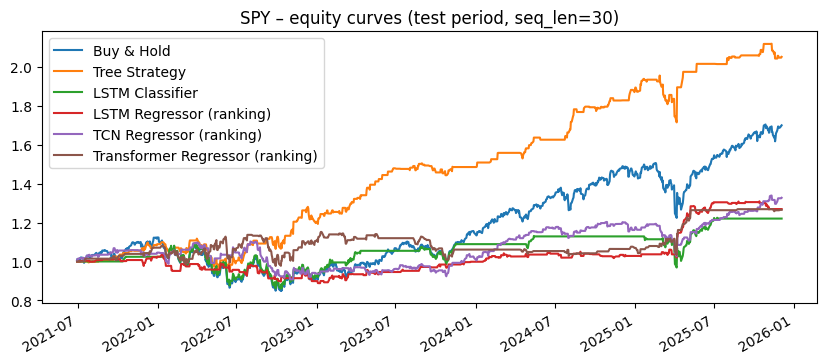

In [20]:
plt.figure(figsize=(10, 4))
equity_bh.plot(label="Buy & Hold")
equity_tree.plot(label="Tree Strategy")
equity_lstm_cls.plot(label="LSTM Classifier")
equity_lstm_reg.plot(label="LSTM Regressor (ranking)")
equity_tcn.plot(label="TCN Regressor (ranking)")
equity_trans.plot(label="Transformer Regressor (ranking)")
plt.legend()
plt.title(f"{ticker} – equity curves (test period, seq_len={seq_len})")
plt.show()



In [21]:
# === Final performance report ===

# 1) Align position series with the common index used for returns
idx_test_full = signals_df.index[split_idx:]

# Buy & Hold: always long
pos_bh = pd.Series(1, index=idx_test_full).loc[common_idx]

# Tree positions (one per test day)
pos_tree_series = pd.Series(positions_tree, index=idx_test_full).loc[common_idx]

# LSTM classifier positions (indexed by dates_test_seq)
pos_lstm_cls_series = pd.Series(positions_lstm_cls, index=dates_test_seq).loc[common_idx]

# LSTM regressor positions (indexed by dates_test_seq_reg)
pos_lstm_reg_series = pd.Series(positions_lstm_reg, index=dates_test_seq_reg).loc[common_idx]

# TCN regressor positions (indexed by dates_test_seq_reg)
pos_tcn_series = pd.Series(positions_tcn, index=dates_test_seq_reg).loc[common_idx]

# Transformer regressor positions (indexed by dates_test_seq_reg)
pos_trans_series = pd.Series(positions_trans, index=dates_test_seq_reg).loc[common_idx]



def long_ratio_and_trades(pos_series: pd.Series) -> tuple[float, int]:
    """Fraction of days long, and number of position changes."""
    vals = pos_series.values
    long_ratio = float((vals == 1).mean())
    trades = int((vals[1:] != vals[:-1]).sum())
    return long_ratio, trades


rows = []
for name, returns, pos in [
    ("Buy & Hold",       bh_common,       pos_bh),
    ("Tree",             tree_common,     pos_tree_series),
    ("LSTM Classifier",  lstm_cls_common, pos_lstm_cls_series),
    ("LSTM Regressor",   lstm_reg_common, pos_lstm_reg_series),
    ("TCN Regressor",    tcn_common,      pos_tcn_series),
    ("Transformer Reg",  trans_common,    pos_trans_series),
]:
    lr, n_trades = long_ratio_and_trades(pos)
    eq = equity_curve_from_returns(returns)
    rows.append({
        "Strategy":   name,
        "CAGR":       cagr(eq),
        "Vol":        annualized_vol(returns),
        "Sharpe":     sharpe_ratio(returns),
        "MaxDD":      max_drawdown(eq),
        "LongRatio":  lr,
        "Trades":     n_trades,
    })

performance_df = pd.DataFrame(rows).set_index("Strategy")
performance_df.round(3)


,CAGR,Vol,Sharpe,MaxDD,LongRatio,Trades
Strategy,,,,,,
Buy & Hold,0.126,0.176,0.825,-0.245,1.000,0
Tree,0.177,0.124,1.493,-0.143,0.325,283
LSTM Classifier,0.046,0.146,0.391,-0.214,0.397,18
LSTM Regressor,0.055,0.097,0.620,-0.143,0.274,238
TCN Regressor,0.065,0.125,0.595,-0.176,0.425,460
Transformer Reg,0.055,0.127,0.497,-0.141,0.268,242


In [22]:
# === Training / Optuna summary ===

train_rows = [
    {
        "Model": "Tree (reg + ranking)",
        "Objective": "Sharpe",
        "BestValObj": -study_tree.best_value,  # this is the best *Sharpe*
        "BestParams": study_tree.best_params,
    },
    {
        "Model": "LSTM Reg (ranking)",
        "Objective": "Sharpe",
        "BestValObj": -study_lstm_reg.best_value,
        "BestParams": study_lstm_reg.best_params,
    },
    {
        "Model": "TCN Reg (ranking)",
        "Objective": "Sharpe",
        "BestValObj": -study_tcn_reg.best_value,
        "BestParams": study_tcn_reg.best_params,
    },
    {
        "Model": "LSTM Classifier",
        "Objective": "log-loss",
        "BestValObj": study_lstm_cls.best_value,  # lower is better
        "BestParams": study_lstm_cls.best_params,
    },
    {
        "Model": "Transformer Reg (ranking)",
        "Objective": "Sharpe",
        "BestValObj": -study_trans_reg.best_value,
        "BestParams": study_trans_reg.best_params,
    },

]

training_df = pd.DataFrame(train_rows)
training_df


,Model,Objective,BestValObj,BestParams
0,Tree (reg + ranking),Sharpe,1.145996,"{'max_depth': 7, 'max_iter': 412, 'learning_ra..."
1,LSTM Reg (ranking),Sharpe,1.964329,"{'hidden_dim': 25, 'num_layers': 1, 'lr': 0.00..."
2,TCN Reg (ranking),Sharpe,1.103982,"{'hidden_dim': 55, 'num_layers': 3, 'kernel_si..."
3,LSTM Classifier,log-loss,0.684457,"{'hidden_dim': 42, 'num_layers': 8, 'lr': 0.00..."
4,Transformer Reg (ranking),Sharpe,1.075581,"{'d_model': 16, 'nhead': 1, 'num_layers': 2, '..."
